![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `8.4` (7 Oct 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **BACKGROUND**

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
    - USTAR filtering (Level-3.3)
    - Gap-filling (Level-4.1)
- Other flux levels are currently not produced in this example:
    
    - NEE Partitioning (Level-4.2)
 
**Important**
- Variable names in the input files need to follow the [FLUXNET convention](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/)

</br>

# **USER SETTINGS**

## Flux variable
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O` ... Nitrous oxide flux
  - `FCH4` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

Set the name of the flux variable in the output file(s), must use the FLUXNET naming convention, e.g. FC, FH2O, LE, ET, H, FN2O, FCH4:

In [1]:
FLUXVAR = "FCH4"

## Site location
- Latitude and longitude of the site where data were recorded. This info is mainly used to calculate potential radiation, which is then used to divide the dataset into daytime and nighttime data.
- UTC offset of the timestamp used in the dataset, important for calculating potential radiation for this location with the correct timestamp.

In [2]:
SITE_LAT = 46.815333  # CH-DAV
SITE_LON = 9.855972  # CH-DAV
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime

## Daytime/nighttime
- Threshold for potential radiation in `W m-2`, records below threshold are considered nighttime

In [3]:
NIGHTTIME_THRESHOLD = 20

## Quality requirements
- The default setting is to accept highest-quality and medium-quality fluxes for daytime (overall quality flag `QCF` = 0 or 1), and highest-quality fluxes only for nighttime (flag `QCF` = 0)
- This strict quality-filtering removes a lot of data points during nighttime

In [4]:
DAYTIME_ACCEPT_QCF_BELOW = 2
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 2

## Source data
- It is possible to load data from (multiple) EddyPro _fluxnet_ output files (data from files will be merged), or directly from one single [parquet](https://parquet.apache.org/) file.
- parquet files are a good option for large datasets because they load and save much faster than when using conventional CSV files.
- For large datasets, it makes sense to first load and merge data from the original EddyPro _fluxnet_ output files, then convert the merged data to one single parquet file and then use this file as input file.

If you want to search for EddyPro _fluxnet_ files in specific locations, you can specify multiple folders here:

In [5]:
# Folders where input file(s) are located
SOURCEDIRS = [r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_das_2023"]  

If you want to load data directly from a specific parquet file, you can specify its name and location here:

In [6]:
# SOURCEDIR = r"L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\40_FLUXES_L1_IRGA+QCL+LGR_mergeData"
# FILENAME = r"41.1_CH-CHA_IRGA_LGR+QCL_Level-1_eddypro_fluxnet_2005-2023_meteo7.parquet"
# from pathlib import Path
# FILEPATH = Path(SOURCEDIR) / FILENAME
# print(f"Data will be loaded from the following file:\n{FILEPATH}")

</br>

# **IMPORTS**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [7]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain, LoadEddyProOutputFiles

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.83.0


</br>

# **DOCSTRING** for `FluxProcessingChain`

In [8]:
# help(FluxProcessingChain)

</br>

</br>

# **LOAD DATA** (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

In [9]:
ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype='EDDYPRO-FLUXNET-CSV-30MIN')
ep.searchfiles()
ep.loadfiles()
maindf = ep.maindf
metadata = ep.metadata

Found 1 files with extension *.csv and file IDs ['eddypro_', '_fluxnet_']:
 Found file #1: F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_das_2023\eddypro_CH-DAS_FR-20240827-124316_fluxnet_2024-08-28T025728_adv.csv
Reading file eddypro_CH-DAS_FR-20240827-124316_fluxnet_2024-08-28T025728_adv.csv ...


</br>

## Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [10]:
# maindf = load_parquet(filepath=FILEPATH)

In [11]:
# # Restrict data range
# maindf = maindf.loc[(maindf.index.year >= 2019) & (maindf.index.year <= 2023)].copy()

</br>

## Check data

In [12]:
display(maindf.head(3))
display(maindf.tail(3))
display(sstats(maindf[FLUXVAR]))

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD    BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  BADM_INST_SA_WIND_FORMAT  BADM_INST_SA_GILL_ALIGN  BADM_SA_OFFSET_NORTH  BADM_INST_MODEL_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INST_GA_CP_TUBE_LENGTH_GA_CO2  BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CO2  ...  W_NONE_MEAS_COV  W_T_SONIC_COV_IBROM  W_T_SONIC_COV_IBROM_N1626  W_T_SONIC_COV_IBROM_N0614  W_T_SONIC_COV_IBROM_N0277  W_T_SONIC_COV_IBROM_N0133  W_T_SONIC_COV_IBROM_N0065  W_T_SONIC_COV_IBROM_N0032  W_T_SONIC_COV_IBROM_N0016  W_T_SONIC_COV_IBROM_N0008  W_T_SONIC_COV_IBROM_N0004  W_NUM_SPIKES  WD_FILTER_NREX  W_SPIKE_NREX  W_ABSLIM_NREX  W_VM97_TEST  W_LGD    W_KID  W_ZCD  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  \
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ...                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2023-05-12 14:45:00  0.028234      1.02218     1032.87  1010.46         0.0                   1.0  0.34915           0.0            46.8154             9.85549              1652.0           0.2                    20.0                     30.0                 NaN                  2.1                       NaN                      NaN                   8.0                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...              NaN             0.017521                   0.017696                   0.017997                   0.018393                   0.018938                   0.019714                   0.020689                   0.021543                   0.021695                   0.020151          14.0             0.0          28.0            0.0  800001100.0   0.05  9.15902   87.0   26.0         2.0             0.0          0.0 -0.013749   
2023-05-12 15:15:00       NaN          NaN         NaN      NaN         NaN                   NaN      NaN           NaN                NaN                 NaN                 NaN           NaN                     NaN                      NaN                 NaN                  NaN                       NaN                      NaN                   NaN                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...              NaN                  NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN                        NaN           NaN             NaN           NaN            NaN          NaN    NaN      NaN    NaN    NaN         NaN             NaN          NaN       NaN   
2023-05-12 15:45:00    

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD    BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  BADM_INST_SA_WIND_FORMAT  BADM_INST_SA_GILL_ALIGN  BADM_SA_OFFSET_NORTH  BADM_INST_MODEL_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INST_GA_CP_TUBE_LENGTH_GA_CO2  BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CO2  ...  W_NONE_MEAS_COV  W_T_SONIC_COV_IBROM  W_T_SONIC_COV_IBROM_N1626  W_T_SONIC_COV_IBROM_N0614  W_T_SONIC_COV_IBROM_N0277  W_T_SONIC_COV_IBROM_N0133  W_T_SONIC_COV_IBROM_N0065  W_T_SONIC_COV_IBROM_N0032  W_T_SONIC_COV_IBROM_N0016  W_T_SONIC_COV_IBROM_N0008  W_T_SONIC_COV_IBROM_N0004  W_NUM_SPIKES  WD_FILTER_NREX  W_SPIKE_NREX  W_ABSLIM_NREX  W_VM97_TEST  W_LGD    W_KID   W_ZCD  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  \
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ...                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2023-12-31 19:15:00  0.027345      1.05671     1065.72  1008.53         0.0                   1.0 -7.57127           0.0            46.8154             9.85549              1652.0           0.2                    20.0                     30.0                 NaN                  2.1                       NaN                      NaN                   8.0                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...              NaN            -0.017936                  -0.017931                  -0.017781                  -0.017360                  -0.016574                  -0.015394                  -0.013851                  -0.011906                  -0.009552                  -0.007215          15.0             0.0          24.0            0.0  800001101.0    0.0  11.1421    41.0   15.0         1.0             0.0          0.0  0.037988   
2023-12-31 19:45:00  0.027325      1.05747     1066.50  1008.54         0.0                   1.0  1.09311           0.0            46.8154             9.85549              1652.0           0.2                    20.0                     30.0                 NaN                  2.1                       NaN                      NaN                   8.0                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...              NaN             0.000371                   0.000388                   0.000413                   0.000450                   0.000512                   0.000601                   0.000673                   0.000707                   0.000748                   0.000794           9.0             0.0          16.0            0.0  800000111.0    0.0  10.5553   489.0   38.0         3.0             0.0          0.0  0.007102   
2023-12-31 20:15:00

FCH4
STARTDATE      2023-05-12 14:45
ENDDATE        2023-12-31 20:15
PERIOD        233 days 05:30:00
NOV                        6898
MISSING                    4298
MISSING_PERC           38.38871
MEAN                  -0.649793
MEDIAN                -0.721755
SD                    14.877524
VAR                  221.340729
SD/MEAN              -22.895797
SUM                -4482.270753
MIN                    -146.367
MAX                     1156.07
P01                  -12.587746
P05                   -5.417592
P25                   -1.942115
P75                    0.478511
P95                    3.416625
P99                   11.400279

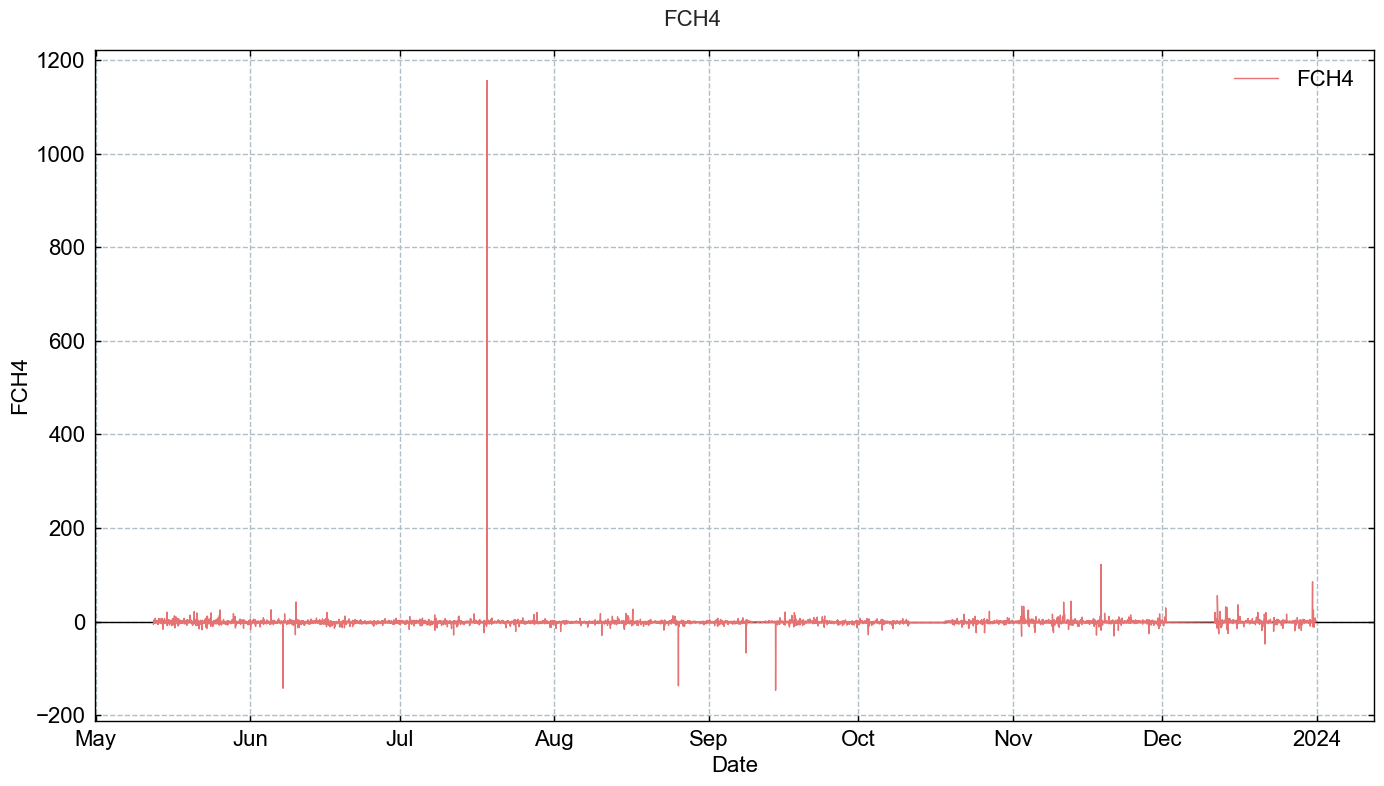

In [13]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

# **START FLUX PROCESSING CHAIN**

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [14]:
fpc = FluxProcessingChain(
    df=maindf,
    fluxcol=FLUXVAR,
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET,    
    nighttime_threshold=NIGHTTIME_THRESHOLD,
    daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
    nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW
)

Detected base variable CH4 for FCH4. (CH4 was used to calculate FCH4.)
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [15]:
fpc.fpc_df

FCH4     USTAR    SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                                        
2023-05-12 14:45:00 -6.033700  0.317190  1020.537364      1.0        0.0
2023-05-12 15:15:00       NaN       NaN   946.219945      1.0        0.0
2023-05-12 15:45:00       NaN       NaN   860.918676      1.0        0.0
2023-05-12 16:15:00 -1.523810  0.149163   766.093087      1.0        0.0
2023-05-12 16:45:00  1.517070  0.122843   663.365669      1.0        0.0
...                       ...       ...          ...      ...        ...
2023-12-31 18:15:00       NaN       NaN     0.000000      0.0        1.0
2023-12-31 18:45:00       NaN       NaN     0.000000      0.0        1.0
2023-12-31 19:15:00  3.586930  0.208989     0.000000      0.0        1.0
2023-12-31 19:45:00 -0.583809  0.143536     0.000000      0.0        1.0
2023-12-31 20:15:00  1.458250  0.074640     0.000000      0.0        1.0

[11196 rows x 5 columns]

</br>

</br>

---

# Level-2: **QUALITY FLAG EXTENSION**

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004:
    - `0` for best quality fluxes
    - `1` for fluxes suitable for general analysis such as annual budgets (although this is debatable for nighttime data)
    - `2` for fluxes that should be discarded from the dataset

In [16]:
TEST_SSITC = True  # Default True

</br>

### Flux base variable completeness test (default: `True`)
- Flag newly calculated here
- Check completeness of the variable that was used to calculate the respective flux
- Example: `CO2` is the base variable that was used to calculate flux `FC`, the test is therefore run on `CO2`
- Checks number of records of the relevant base variable available for each averaging Interval and calculates completeness flag as follows:
    - `0` for files where >= 99% of base variable are available
    - `1` for files where >= 97% and < 99% of base variable are available
    - `2` for files where < 97% of base variable are available
 
List of flux base variables and the corresponding fluxes:
- `CO2`: used to calculate `FC`
- `H2O`: used to calculate `FH2O`
- `H2O`: used to calculate `LE`
- `H2O`: used to calculate `ET`
- `T_SONIC`: used to calculate `H`
- `N2O`: used to calculate `FN2O`
- `CH4`: used to calculate `FCH4`

In [17]:
TEST_GAS_COMPLETENESS = False  # Default True

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `SCF` variable in EddyPro output file

In [18]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # Default True

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration/temperature was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold

In [19]:
# Signal strength
TEST_SIGNAL_STRENGTH = False
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Typical variable name in fluxnet files
TEST_SIGNAL_STRENGTH_METHOD = 'discard above'
TEST_SIGNAL_STRENGTH_THRESHOLD = 90

In [ ]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
# TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

</br>

### Raw data screening tests
- Flags were calculated in EddyPro
- See here for more details: [Despiking and raw data statistical screening (EddyPro help)](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html)

In [20]:
TEST_RAWDATA = True  # Default True
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = True  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro
- Flag can be useful during some time periods when the sonic anemometer had issues
- Not used by default (similar to ICOS)

In [21]:
TEST_RAWDATA_ANGLE_OF_ATTACK = False  # Default False
TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = [['2008-01-01', '2010-01-01'],
                                                  ['2016-03-01', '2016-05-01']]  # Default False

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [22]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [23]:
LEVEL2_SETTINGS = {
    'signal_strength': {
        'apply': TEST_SIGNAL_STRENGTH,
        'signal_strength_col': TEST_SIGNAL_STRENGTH_COL,
        'method': TEST_SIGNAL_STRENGTH_METHOD,
        'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {
        'apply': TEST_RAWDATA,
        'spikes': TEST_RAWDATA_SPIKES,
        'amplitude': TEST_RAWDATA_AMPLITUDE,
        'dropout': TEST_RAWDATA_DROPOUT,
        'abslim': TEST_RAWDATA_ABSLIM,
        'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF,
        'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF,
        'discont_hf': TEST_RAWDATA_DISCONT_HF,
        'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': {
        'apply': TEST_SSITC},
    'gas_completeness': {
        'apply': TEST_GAS_COMPLETENESS},
    'spectral_correction_factor': {
        'apply': TEST_SPECTRAL_CORRECTION_FACTOR},
    'angle_of_attack': {
        'apply': TEST_RAWDATA_ANGLE_OF_ATTACK,
        'application_dates': TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES},
    'steadiness_of_horizontal_wind': {
        'apply': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND}
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)

[MissingValues]  running MissingValues ...
SSITC TEST: Generated new flag variable FLAG_L2_FCH4_SSITC_TEST, values taken from output variable FCH4_SSITC_TEST ...
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FCH4_SCF_TEST, newly calculated from output variable FCH4_SCF, withflag 0 (good values) where FCH4_SCF < 2, flag 1 (ok values) where FCH4_SCF >= 2 and < 4, flag 2 (bad values) where FCH4_SCF >= 4...
RAW DATA TEST: Generated new flag variable FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST, values taken from output variable CH4_VM97_TEST from position 1, based on CH4, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...
RAW DATA TEST: Generated new flag variable FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST, values taken from output variable CH4_VM97_TEST from position 2, based on CH4, with flag 0 (good values) where test passed, flag 2 (bad values) where test

</br>

</br>

## **Finalize Level-2**

In [24]:
fpc.finalize_level2()

++Added new column FLAG_L2_FCH4_MISSING_TEST.
++Added new column FLAG_L2_FCH4_SSITC_TEST.
++Added new column FLAG_L2_FCH4_SCF_TEST.
++Added new column FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST.
++Added new column FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST.
++Added new column SUM_L2_FCH4_HARDFLAGS.
++Added new column SUM_L2_FCH4_SOFTFLAGS.
++Added new column SUM_L2_FCH4_FLAGS.
++Added new column FLAG_L2_FCH4_QCF.
++Added new column FCH4_L2_QCF.
++Added new column FCH4_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [25]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FCH4_MISSING_TEST',
 'FLAG_L2_FCH4_SSITC_TEST',
 'FLAG_L2_FCH4_SCF_TEST',
 'FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST',
 'FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST',
 'SUM_L2_FCH4_HARDFLAGS',
 'SUM_L2_FCH4_SOFTFLAGS',
 'SUM_L2_FCH4_FLAGS',
 'FLAG_L2_FCH4_QCF',
 'FCH4_L2_QCF',
 'FCH4_L2_QCF0']

</br>

### Plots

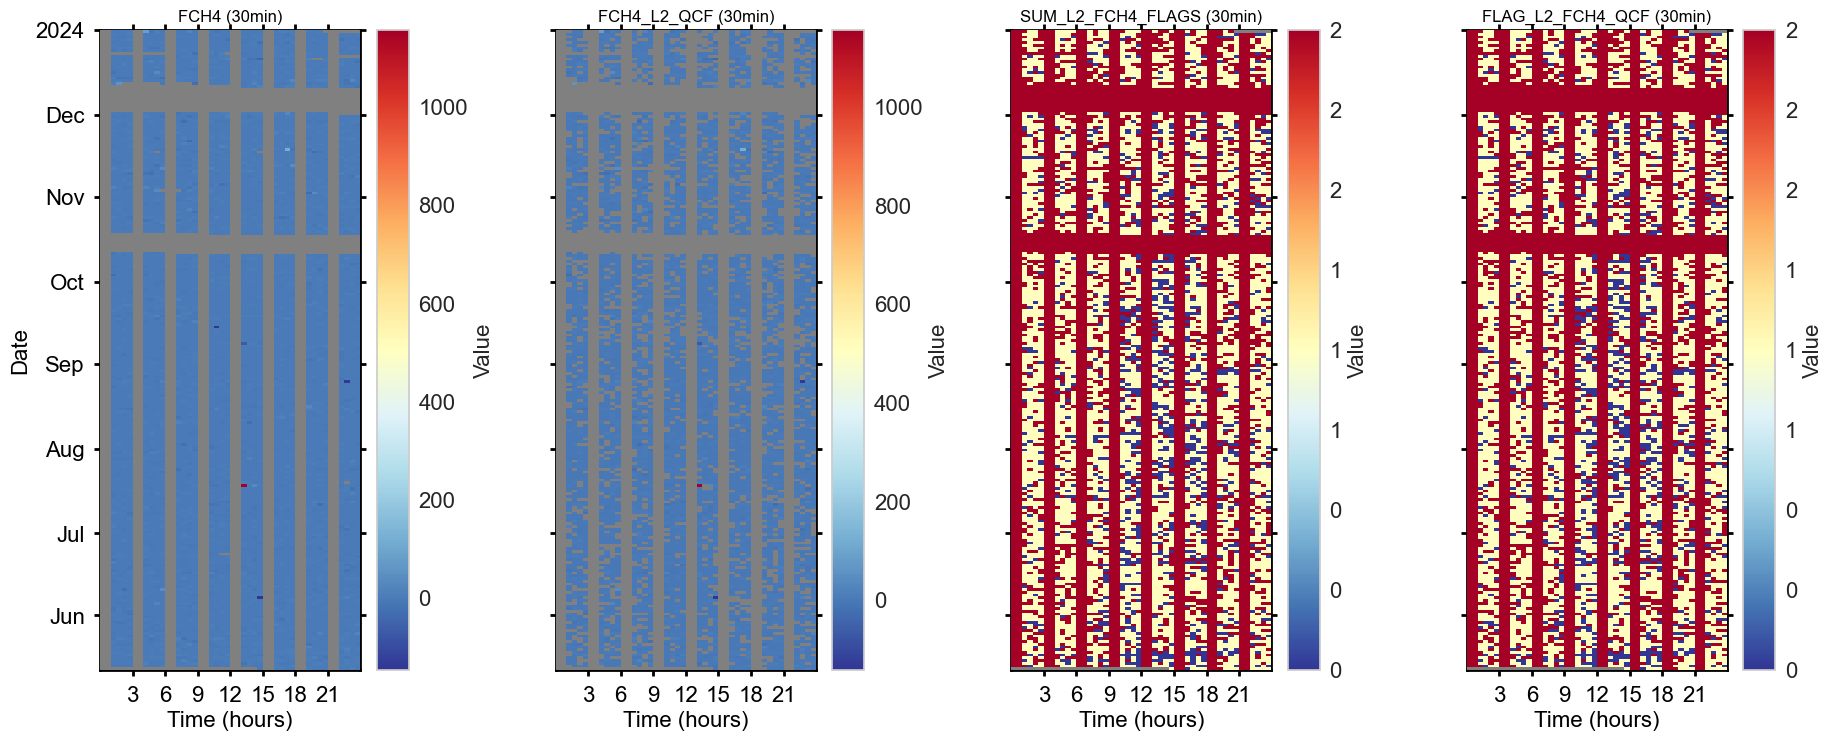

In [26]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [ ]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [27]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FCH4.

Number of FCH4 records before QC: 6898
+++ FLAG_L2_FCH4_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 6898 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FCH4_SSITC_TEST rejected 1516 values (+21.98%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976

In [28]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FCH4_QCF, QCF FLAG FOR FCH4
Between 2023-05-12 14:45 and 2023-12-31 20:15 ...
    Total flux records BEFORE quality checks: 6898 (61.61% of potential)
    Available flux records AFTER quality checks: 5382 (78.02% of total)
    Rejected flux records: 1516 (21.98% of total)
    Potential flux records: 11196
    Potential flux records missed: 4298 (38.39% of potential)



In [ ]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# Level-3.1: **STORAGE CORRECTION**

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using the rolling mean in an expanding window.
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [29]:
fpc.level31_storage_correction(gapfill_storage_term=True)

Detected storage variable SCH4_SINGLE for FCH4.
Calculating storage-corrected flux FCH4_L3.1 from flux FCH4 and storage term SCH4_SINGLE ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 1733
Gap-filling storage-term SCH4_SINGLE with rolling median (window size = 3 records) ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 1733
Gap-filling storage-term SCH4_SINGLE with rolling median (window size = 5 records) ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 1733
Gap-filling storage-term SCH4_SINGLE with rolling median (window size = 7 records) ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 12
Gap-filling storage-term SCH4_SINGLE with rolling median (window size = 9 records) ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 8
Gap-filling storage-term SCH4_SINGLE with rolling median (window size = 11 records) ...
Missing values for storage term SCH4_SINGLE_gfRMED_L3.1: 4
Gap-filling storage-term SCH4_SINGLE with rolling median (w

</br>

## **Finalize Level-3.1**

In [30]:
fpc.finalize_level31()

++Added new column SCH4_SINGLE.
++Added new column SCH4_SINGLE_gfRMED_L3.1.
++Added new column FLAG_SCH4_SINGLE_gfRMED_L3.1_ISFILLED.
++Added new column FCH4_L3.1.
++Added new column FCH4_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column FCH4_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [31]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['SCH4_SINGLE_gfRMED_L3.1',
 'FLAG_SCH4_SINGLE_gfRMED_L3.1_ISFILLED',
 'FCH4_L3.1',
 'FCH4_L3.1_QCF',
 'FCH4_L3.1_QCF0']

</br>

### Plots

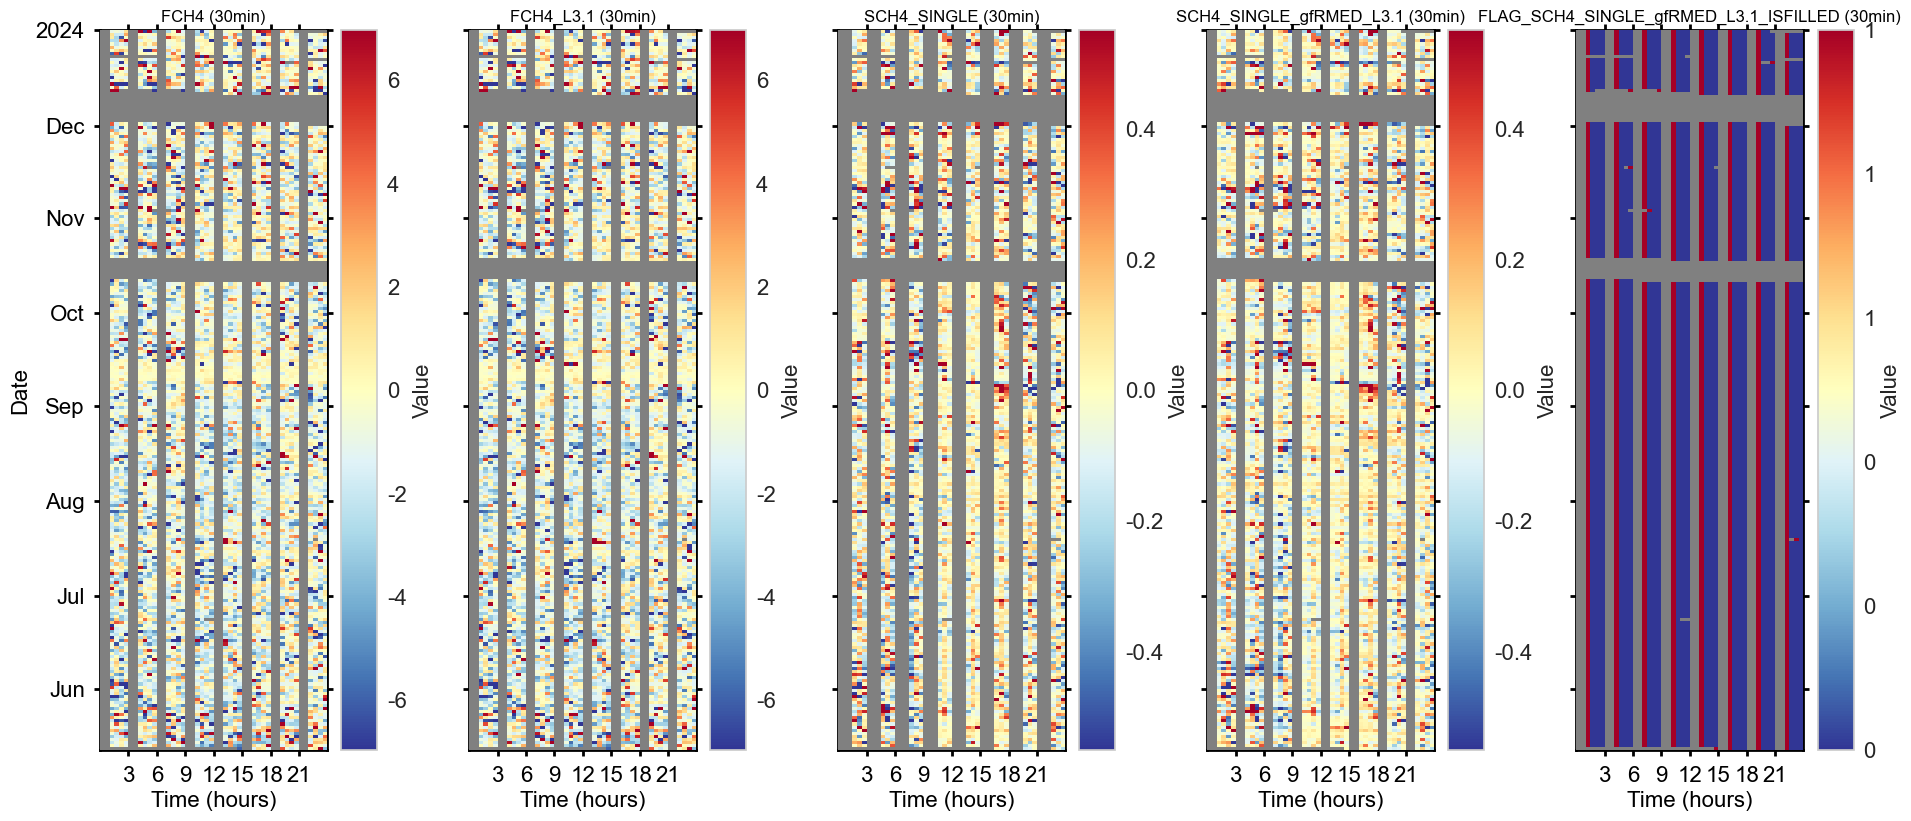

In [32]:
fpc.level31.showplot()

</br>

### Report

In [33]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FCH4
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term SCH4_SINGLE_gfRMED_L3.1 was added to flux FCH4.
The storage-corrected flux was stored as FCH4_L3.1.

The flux was available for 6898 records (FCH4).
The original, non-gapfilled storage term was available for 5165 records (SCH4_SINGLE).
The original storage term SCH4_SINGLE was missing for 1733 flux records.
Without gap-filling the storage term (SCH4_SINGLE), 1733 measured flux records (FCH4) are lost.

For this run, gap-filling of SCH4_SINGLE was * SELECTED *.
After gap-filling the storage term, it was available for an additional 1733 records (SCH4_SINGLE_gfRMED_L3.1).

In the storage-corrected flux FCH4_L3.1 with 6898 records, 
  - 74.9% (5165 records) of used storage terms come from originally calculated data (SCH4_SINGLE)
  - 25.1% (1733 records) of used storage terms come from gap-filled data (SCH4_SINGLE_gfRMED_L3.1)

Stats for gap-filled storage terms:
     

</br>

---    

# Optional: **Analyze highest-quality flux** (so far)
- Analysis of fluxes after Level-3.1 where the overall quality flag `QCF` = 0
- This helps in understanding in what range the "true" flux occurs
- Here, the highest-quality fluxes are additionally filtered for outlier values using the relatively fast Local Outlier Factor test
- For this quick analysis, it is possible that the outlier test cuts off some "real" values that should be retained, but it nevertheless helps in understanding the flux range
- `QCF` = 0 is best quality, `QCF` = medium quality, `QCF` = 2 bad quality and always rejected
- The difference between quality 0 and quality 1 or 2 is huge

>>> Removing outliers from highest-quality DAYTIME fluxes (FCH4_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=6, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 15 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 DAYTIME:   7.434713
>>> Smallest non-outlier flux >= 0 DAYTIME:  0.020174950000000004
>>> Largest non-outlier flux < 0 DAYTIME:    -0.004998999999999976
>>> Smallest non-outlier flux < 0 DAYTIME:   -9.2093966
>>> Removing outliers from highest-quality NIGHTTIME fluxes (FCH4_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=3, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 60 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 NIGHTTIME:   2.624785
>>> Smallest non-outlier flux >= 0 NIGHTTIME:  0.014386

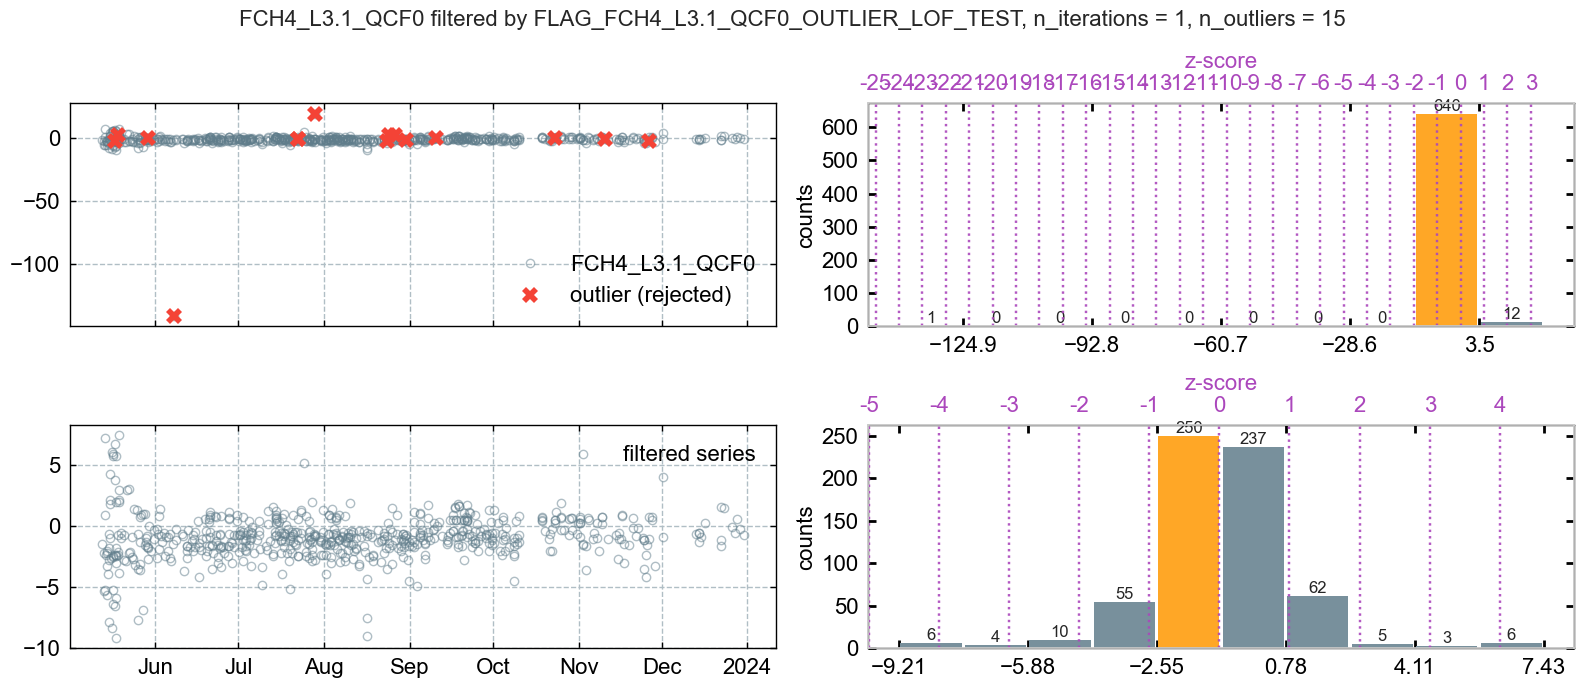

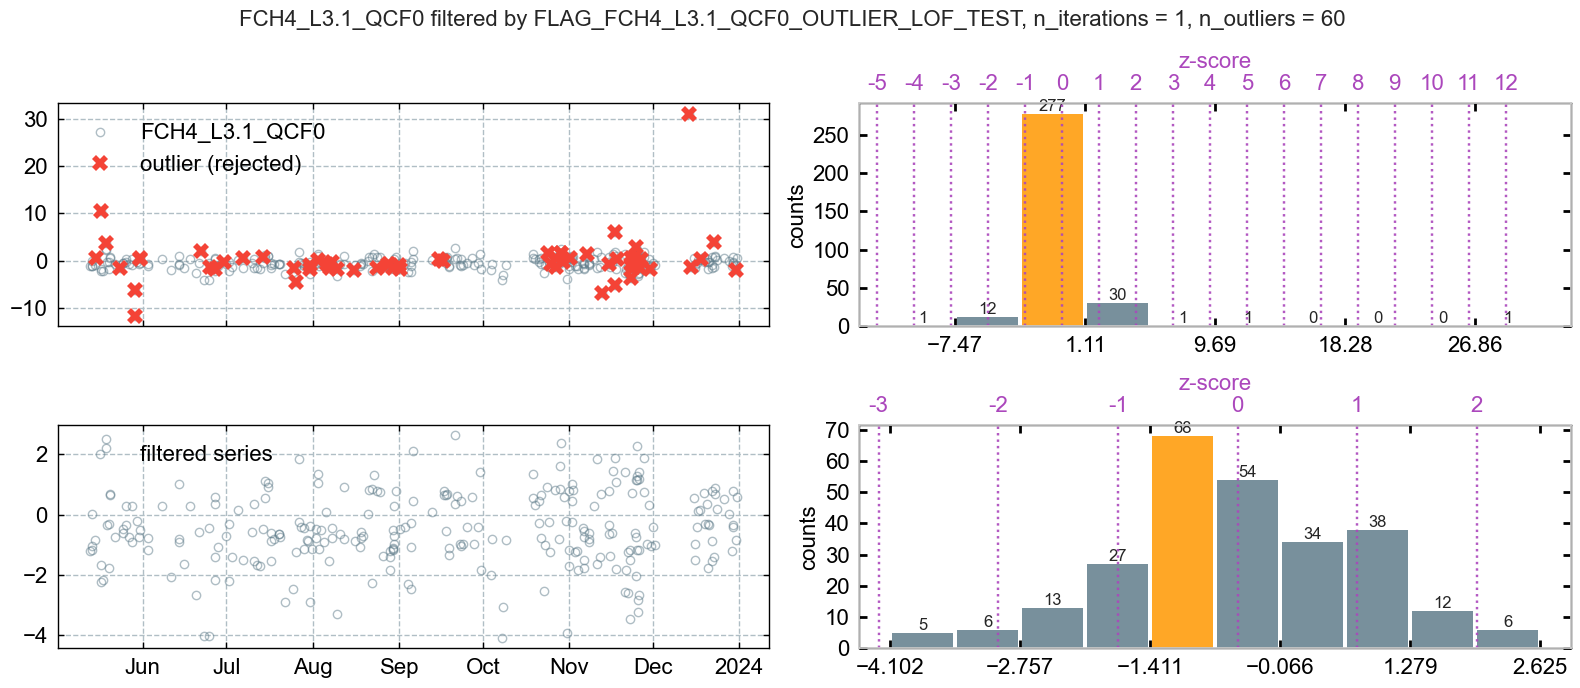

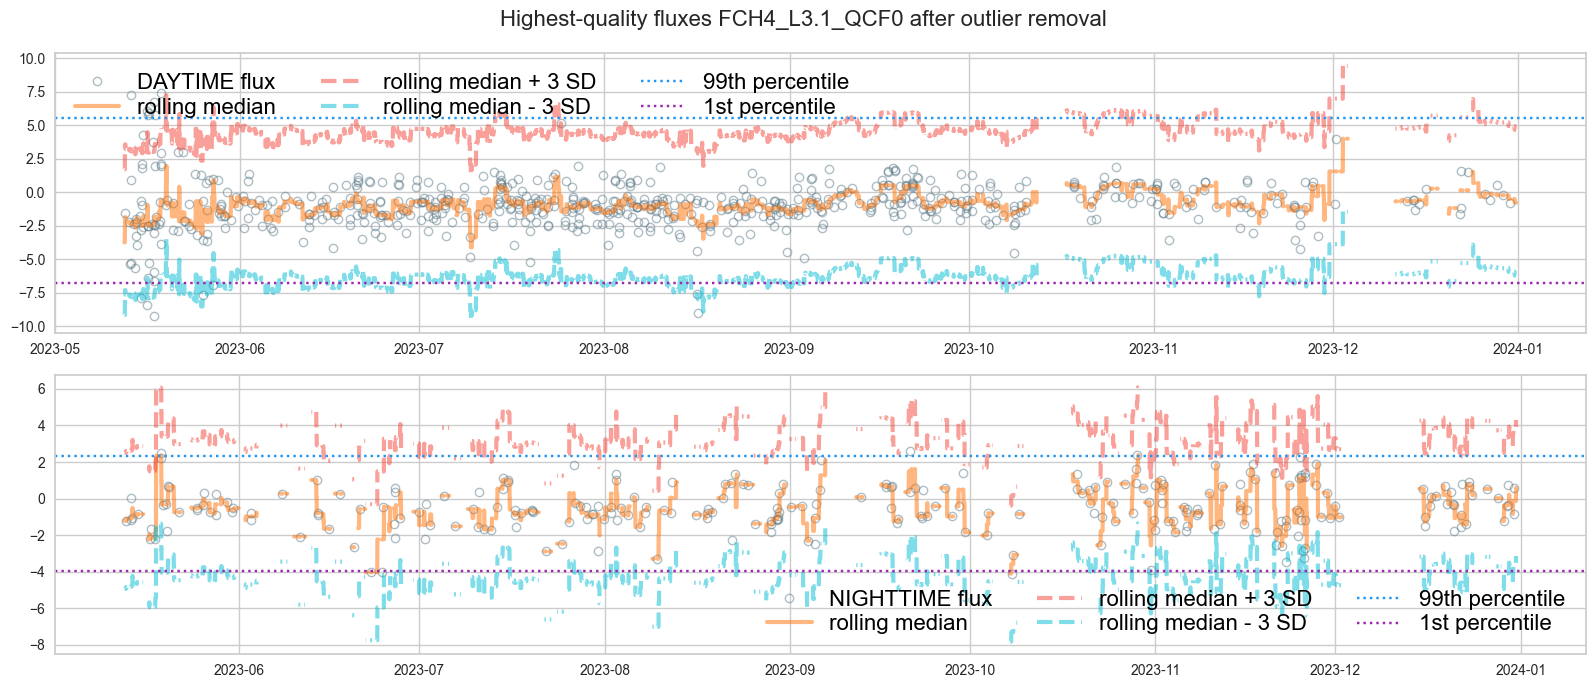

In [34]:
analyze_highest_quality_flux(flux=fpc.fpc_df[fpc.filteredseries_hq.name], nighttime_flag=fpc.fpc_df['NIGHTTIME'])

---

</br>

# Level-3.2: **OUTLIER DETECTION**
- Running an outlier test creates a *preview* plot of the results
- If the output looks as desired, run `fpc.level32_addflag()` cell below the preview to accept the results you see in the plot
- All subsequent tests will then be based on these results
- This means that each test is run on the data already filtered by the previous test
- Each test creates its own quality flag
- At the end of Level-3.2, an overall quality flag `QCF` is created that combines all of the individual flags into one single flag

</br>

## Plot time series

In [35]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

FCH4_L3.1_QCF 
(quality-controlled Level-3.1 version of FCH4)


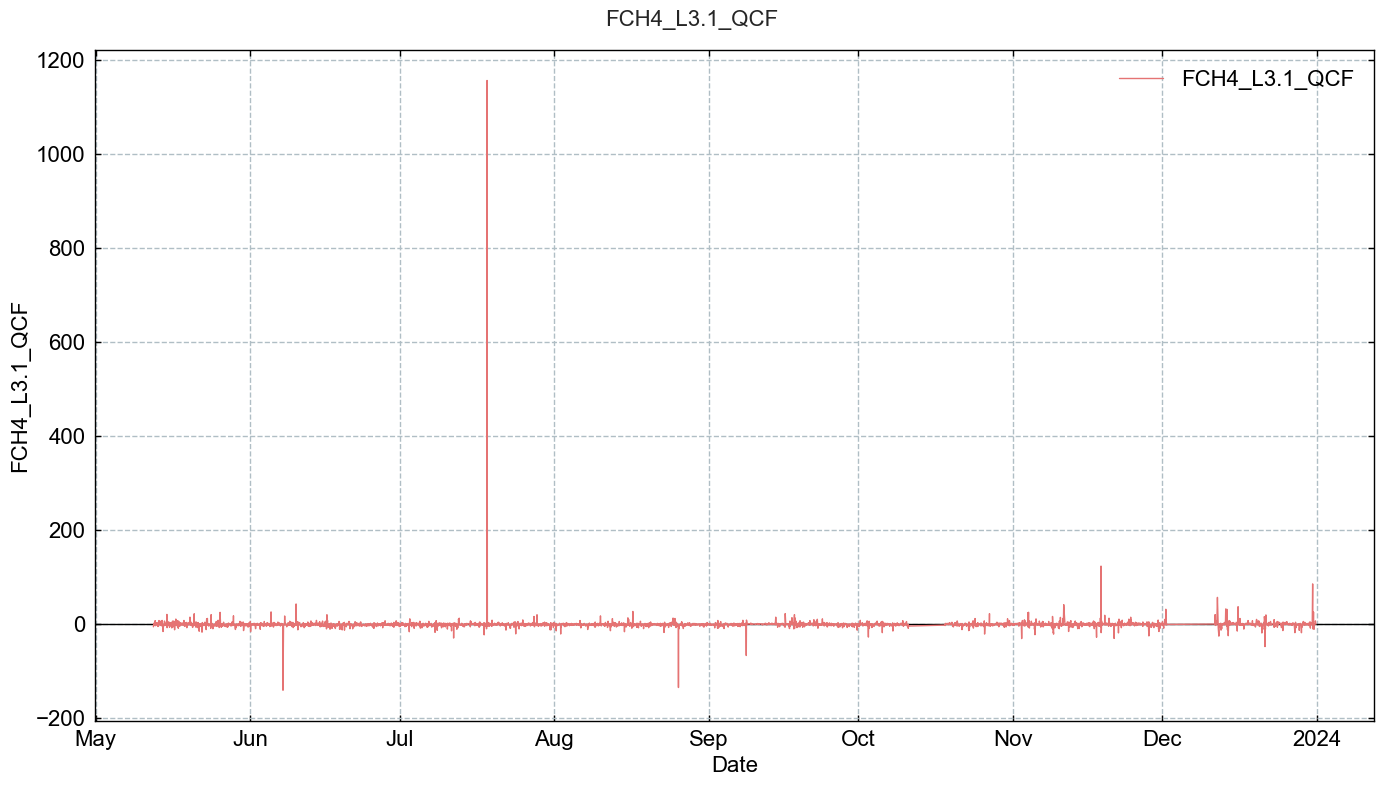

In [37]:
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [38]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Outlier flag: **Absolute limits**
- remove values outside a physically plausible range
- typical value for CO2 flux `FC`: +/-50 µmol m-2 s-1
- typical value for latent evaporation flux `LE`: +800 / -50 W m-2
- typical value for sensible heat flux `H`: +400 / -200 W m-2

In [39]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
# help(AbsoluteLimits)

[AbsoluteLimits]  running AbsoluteLimits ...


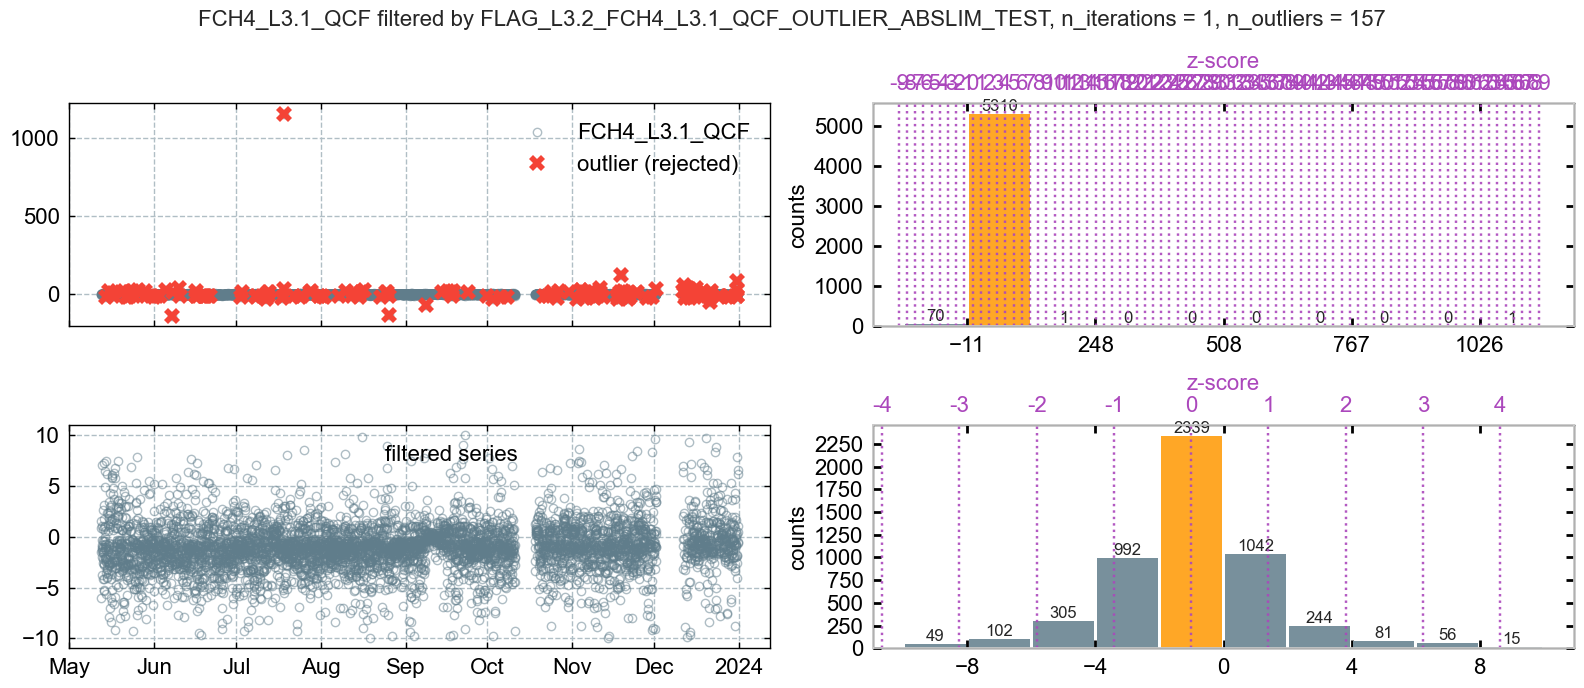

In [40]:
MIN = -10
MAX = 10
fpc.level32_flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [41]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Outlier flag: **Manual flag**
- The interactive plot can be used to determine the exact start and end of time ranges or data points that need to be removed, e.g. due to known instrument failure

In [ ]:
# from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
# help(ManualRemoval)

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False

In [ ]:
# REMOVE_DATES = [
#     ['2022-03-18 12:15:00', '2022-05-03 06:45:00'],  # Removes date range between two datetimes (inclusive)
#     # '2023-12-12 12:45:00'  # Removes data point with specific timestamp
# ]
# fpc.level32_flag_manualremoval_test(
#     remove_dates=REMOVE_DATES,
#     showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False

</br>

</br>

## Outlier flag: **Hampel filter**, separate for daytime and nighttime
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 43 seconds on a fast desktop computer

In [ ]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

In [ ]:
# %%time
# WINDOW_LENGTH = 48 * 3
# N_SIGMA_DT = 3.5
# N_SIGMA_NT = 3.5
# fpc.level32_flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT,
#                                            showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **z-score across all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScore
# help(zScore)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Hampel filter**
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 33 seconds on a fast desktop computer
    - tested with 19 years of 30MIN time resolution data and it needed approx. 20 minutes on a fast desktop computer

In [ ]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

[Hampel]  running Hampel ...
ITERATION#1: Total found outliers: 31 values
ITERATION#2: Total found outliers: 0 values
CPU times: total: 6.61 s
Wall time: 6.75 s


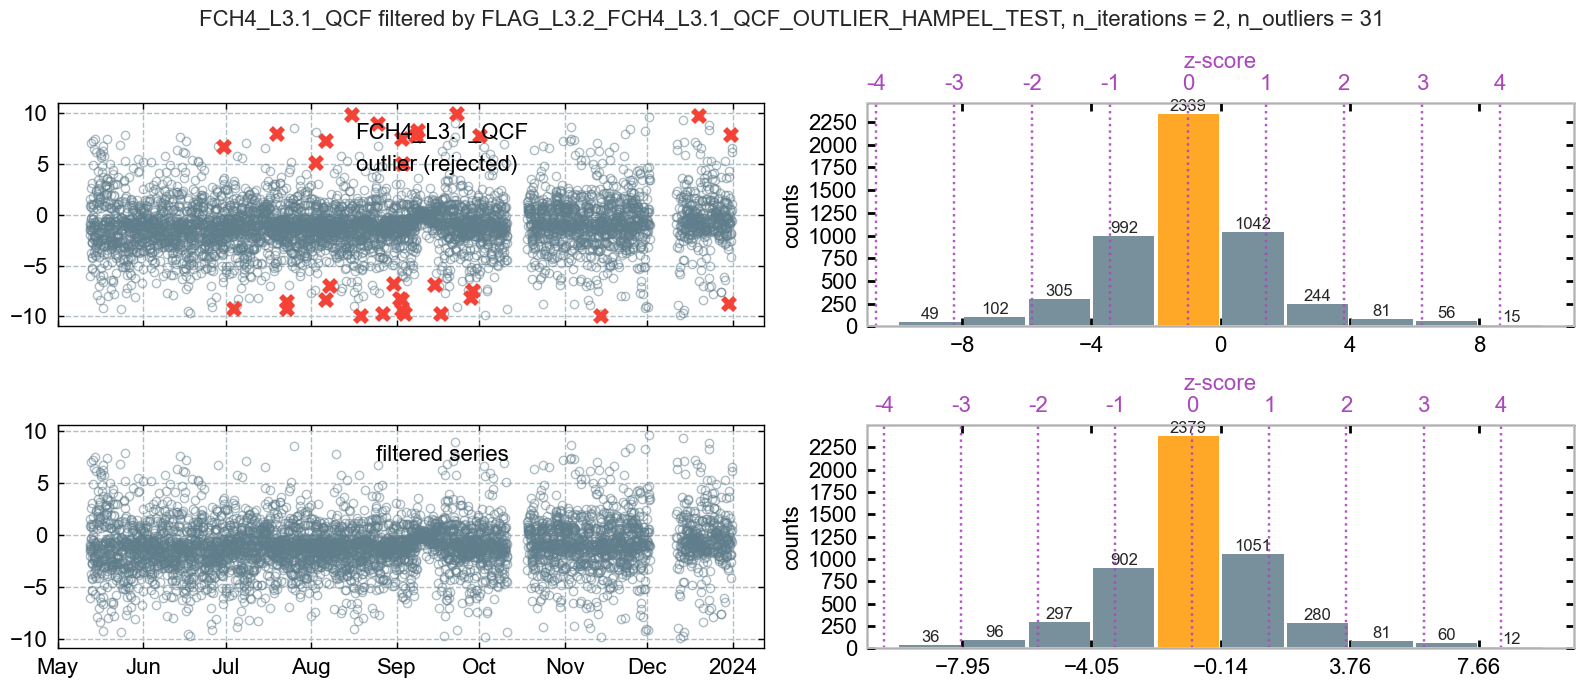

In [42]:
%%time
WINDOW_LENGTH = 48 * 3
N_SIGMA = 5.5
fpc.level32_flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=True)

In [43]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_HAMPEL_TEST to flag data


</br>

</br>

## Outlier flag: **z-score over all data**, separate for daytime and nighttime

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
# help(zScoreDaytimeNighttime)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Rolling z-score over all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreRolling
# help(zScoreRolling)

In [ ]:
# THRES_ZSCORE = 5.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_zscore_rolling_test(winsize=WINSIZE, thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *rolling* standard deviation

In [ ]:
# from diive.pkgs.outlierdetection.localsd import LocalSD
# help(LocalSD)

In [ ]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

In [ ]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Increments z-score**

In [ ]:
# from diive.pkgs.outlierdetection.incremental import zScoreIncrements
# help(zScoreIncrements)

In [ ]:
# THRES_ZSCORE = 4
# fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**, daytime/nighttime
- Test is run separately for daytime and nighttime data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
# help(LocalOutlierFactorDaytimeNighttime)

In [ ]:
# N_NEIGHBORS = 100
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**
- Test is run across all data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
# help(LocalOutlierFactorAllData)

In [ ]:
# N_NEIGHBORS = 24
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Absolute limits**, separate for daytime and nighttime data

In [ ]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
# help(AbsoluteLimitsDaytimeNighttime)

In [ ]:
# MIN_DT = -50
# MAX_DT = 50
# MIN_NT = -25
# MAX_NT = 25
# fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Trim nighttime flux data**

In [ ]:
# from diive.pkgs.outlierdetection.trim import TrimLow
# help(TrimLow)

In [ ]:
# fpc.level32_flag_outliers_trim_low_test(trim_nighttime=True, lower_limit=-5, showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## **Finalize Level-3.2**: Calculate overall quality flag (so far)

In [44]:
fpc.finalize_level32()

++Added new column FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_HAMPEL_TEST.
++Added new column SUM_L3.2_FCH4_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_FCH4_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_FCH4_L3.1_FLAGS.
++Added new column FLAG_L3.2_FCH4_L3.1_QCF.
++Added new column FCH4_L3.1_L3.2_QCF.
++Added new column FCH4_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [45]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_HAMPEL_TEST',
 'SUM_L3.2_FCH4_L3.1_HARDFLAGS',
 'SUM_L3.2_FCH4_L3.1_SOFTFLAGS',
 'SUM_L3.2_FCH4_L3.1_FLAGS',
 'FLAG_L3.2_FCH4_L3.1_QCF',
 'FCH4_L3.1_L3.2_QCF',
 'FCH4_L3.1_L3.2_QCF0']

</br>

### Plot filtered flux after Level-3.2
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal
- flux after Level-3.2, after outlier removal
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

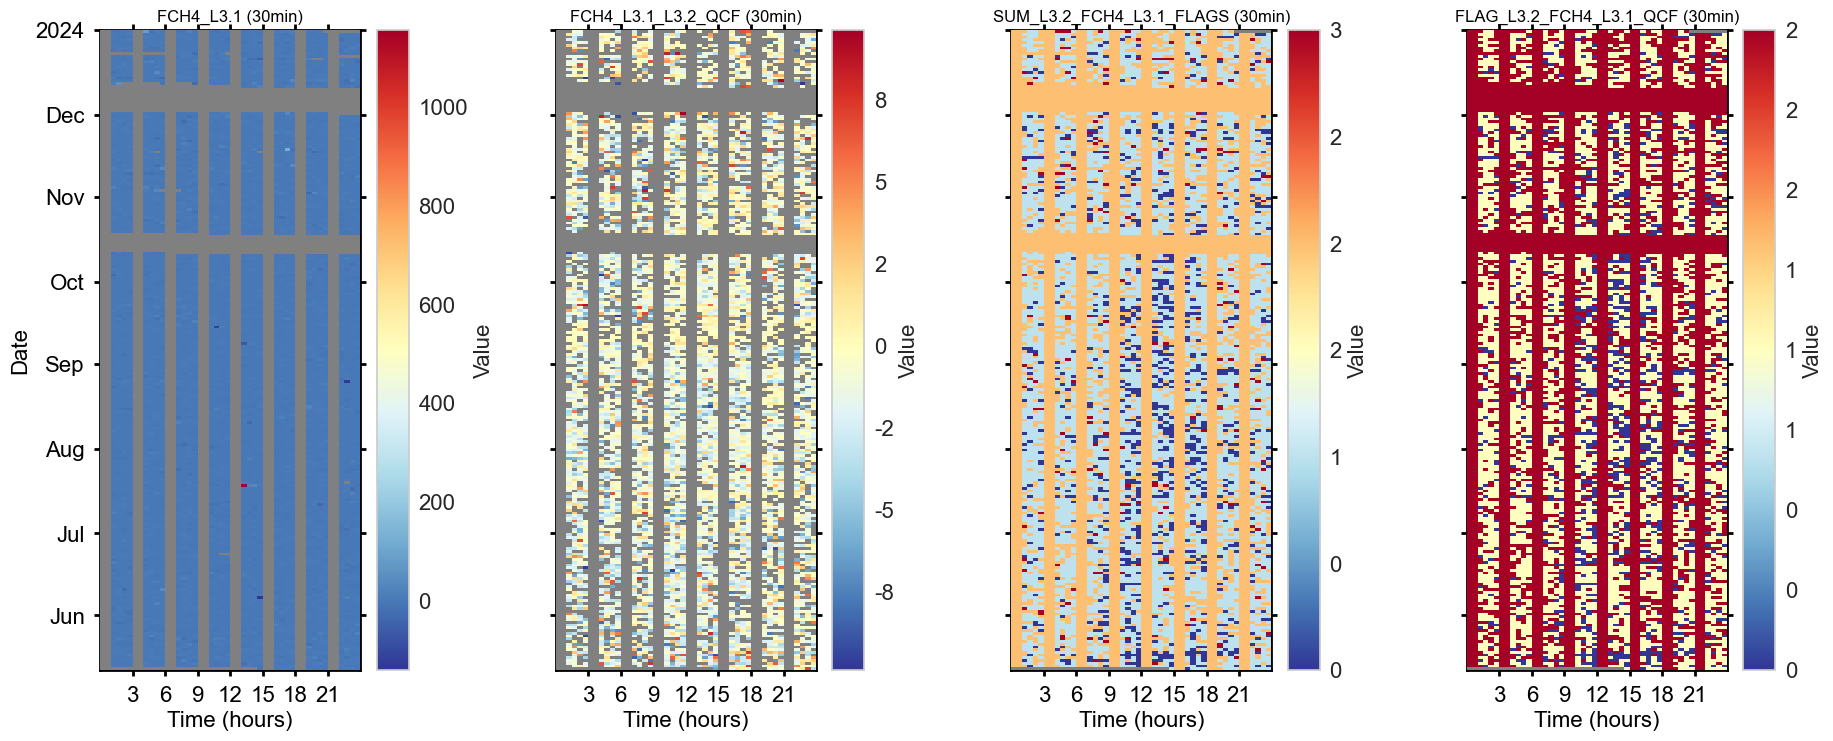

In [46]:
fpc.level32_qcf.showplot_qcf_heatmaps()

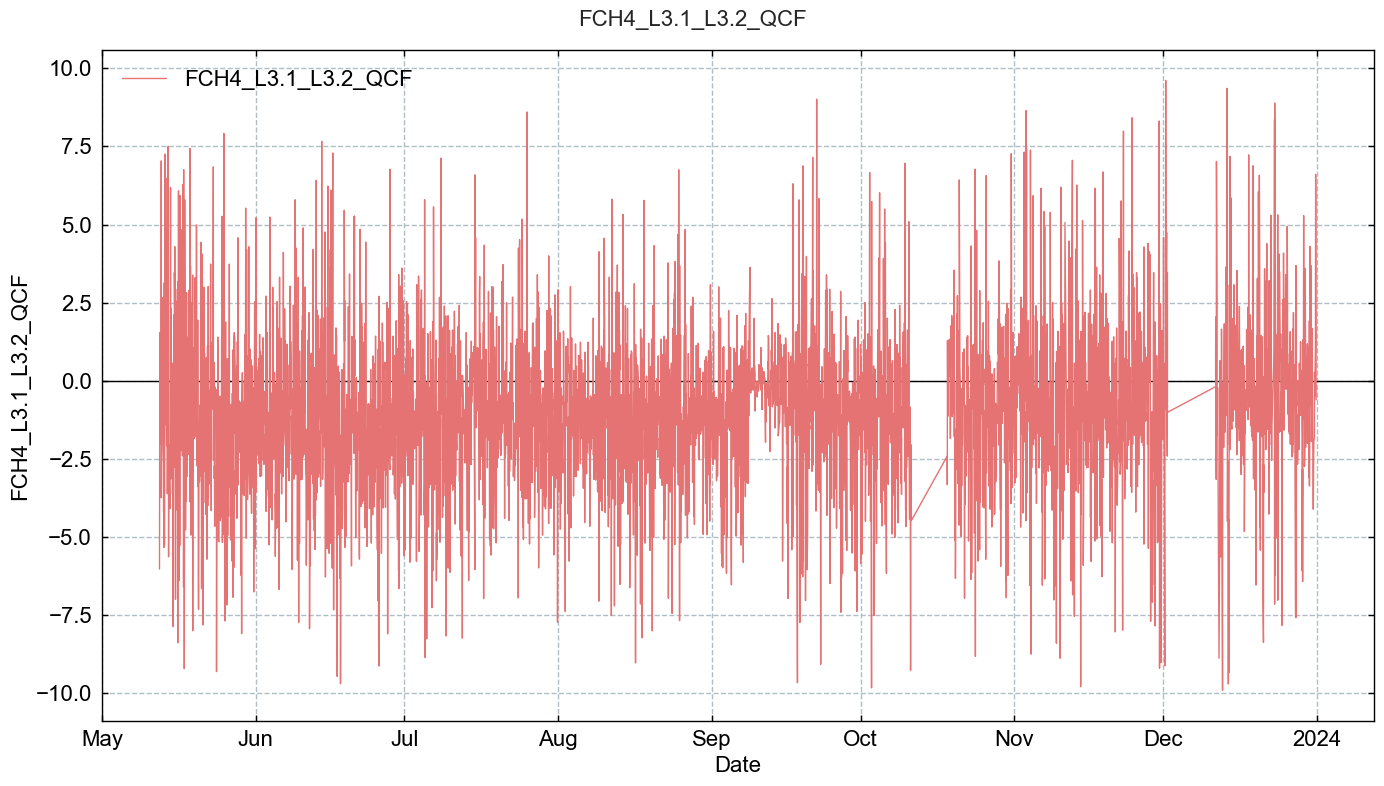

In [47]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [ ]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [48]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FCH4_L3.1.

Number of FCH4_L3.1 records before QC: 6898
+++ FLAG_L2_FCH4_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 6898 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FCH4_SSITC_TEST rejected 1516 values (+21.98%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: f

In [49]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_FCH4_L3.1_QCF, QCF FLAG FOR FCH4_L3.1
Between 2023-05-12 14:45 and 2023-12-31 20:15 ...
    Total flux records BEFORE quality checks: 6898 (61.61% of potential)
    Available flux records AFTER quality checks: 5194 (75.30% of total)
    Rejected flux records: 1704 (24.70% of total)
    Potential flux records: 11196
    Potential flux records missed: 4298 (38.39% of potential)



In [50]:
fpc.level32_qcf.report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FCH4_MISSING_TEST:
    OVERALL flag 0.0: 6898 values (61.61%)  
    OVERALL flag 2.0: 4298 values (38.39%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 3583 values (62.64%)  
    DAYTIME flag 2.0: 2137 values (37.36%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 3315 values (60.54%)  
    NIGHTTIME flag 2.0: 2161 values (39.46%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FCH4_SSITC_TEST:
    OVERALL flag 0.0: 976 values (8.72%)  
    OVERALL flag 1.0: 4406 values (39.35%)  
    OVERALL flag 2.0: 1516 values (13.54%)  
    OVERALL flag missing: 4298 values (38.39%)  

    DAYTIME flag 0.0: 653 values (11.42%)  
    DAYTIME flag 1.0: 2219 values (38.79%)  
    DAYTIME flag 2.0: 711 values (12.43%)  
    DAYTIME flag missing: 2137 values (37.36%)  

    NIGHTTIME flag 0.0: 323 values (5.90%)  
    NIGHTTIME flag 1.0: 2187 values (39.94%)  

</br>

## Save Level-3.2 results to file
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. USTAR filtering is not needed and gap-filling is done elsewhere (ReddyProc...)

In [51]:
# results_df = fpc.get_data()
# filename = "51.1_FluxProcessingChain_after-L3.3_NEE"
# results_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=results_df, filename=filename)

</br>

# Level-3.3: **USTAR FILTERING**
- Daytime and nighttime data are filtered based on USTAR thresholds

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



In [52]:
USTAR_SCENARIOS = ['CUT_16', 'CUT_50', 'CUT_84']
USTAR_THRESHOLDS = [0.06, 0.08, 0.1]
fpc.level33_constant_ustar(thresholds=USTAR_THRESHOLDS,
                           threshold_labels=USTAR_SCENARIOS,
                           showplot=False)

[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_16 0.06: 1938 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_50 0.08: 3208 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_84 0.1: 4185 values


</br>

## **Finalize Level-3.3**: Caculate overall final quality flag

In [53]:
# Finalize: stores results for each USTAR scenario in a dict
fpc.finalize_level33()

Calculating overall quality flag QCF for USTAR scenario CUT_16...
++Added new column FLAG_L3.3_CUT_16_FCH4_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT_16_FCH4_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT_16_FCH4_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT_16_FCH4_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT_16_FCH4_L3.1_QCF.
++Added new column FCH4_L3.1_L3.3_CUT_16_QCF.
++Added new column FCH4_L3.1_L3.3_CUT_16_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT_50...
++Added new column FLAG_L3.3_CUT_50_FCH4_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT_50_FCH4_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT_50_FCH4_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT_50_FCH4_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT_50_FCH4_L3.1_QCF.
++Added new column FCH4_L3.1_L3.3_CUT_50_QCF.
++Added new column FCH4_L3.1_L3.3_CUT_50_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT_84...
++Added new column FLAG_L3.3_CUT_84_FCH4_L3.1_USTAR_TEST.
++Added new 

</br>

### Available `Level-3.3` variables
- This shows all available Level-3.3 variables for this flux

In [54]:
[x for x in fpc.fpc_df.columns if 'L3.3' in x]

['FLAG_L3.3_CUT_16_FCH4_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT_16_FCH4_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT_16_FCH4_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT_16_FCH4_L3.1_FLAGS',
 'FLAG_L3.3_CUT_16_FCH4_L3.1_QCF',
 'FCH4_L3.1_L3.3_CUT_16_QCF',
 'FCH4_L3.1_L3.3_CUT_16_QCF0',
 'FLAG_L3.3_CUT_50_FCH4_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT_50_FCH4_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT_50_FCH4_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT_50_FCH4_L3.1_FLAGS',
 'FLAG_L3.3_CUT_50_FCH4_L3.1_QCF',
 'FCH4_L3.1_L3.3_CUT_50_QCF',
 'FCH4_L3.1_L3.3_CUT_50_QCF0',
 'FLAG_L3.3_CUT_84_FCH4_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT_84_FCH4_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT_84_FCH4_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT_84_FCH4_L3.1_FLAGS',
 'FLAG_L3.3_CUT_84_FCH4_L3.1_QCF',
 'FCH4_L3.1_L3.3_CUT_84_QCF',
 'FCH4_L3.1_L3.3_CUT_84_QCF0']

</br>

### Plot filtered flux after Level-3.3
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal and USTAR filtering
- flux after Level-3.3, after outlier removal and USTAR filtering
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

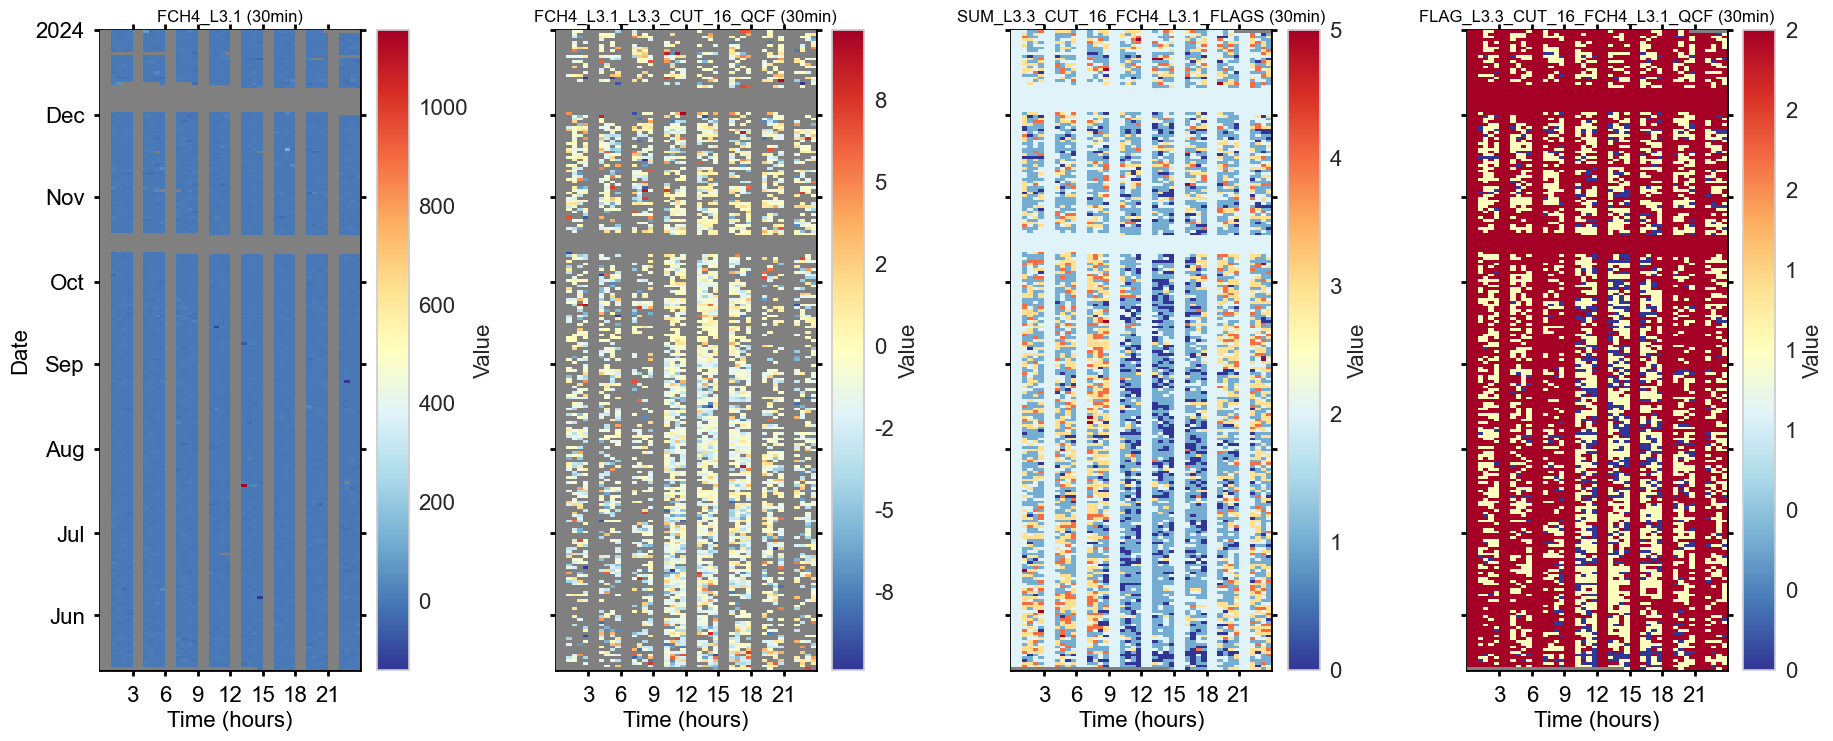

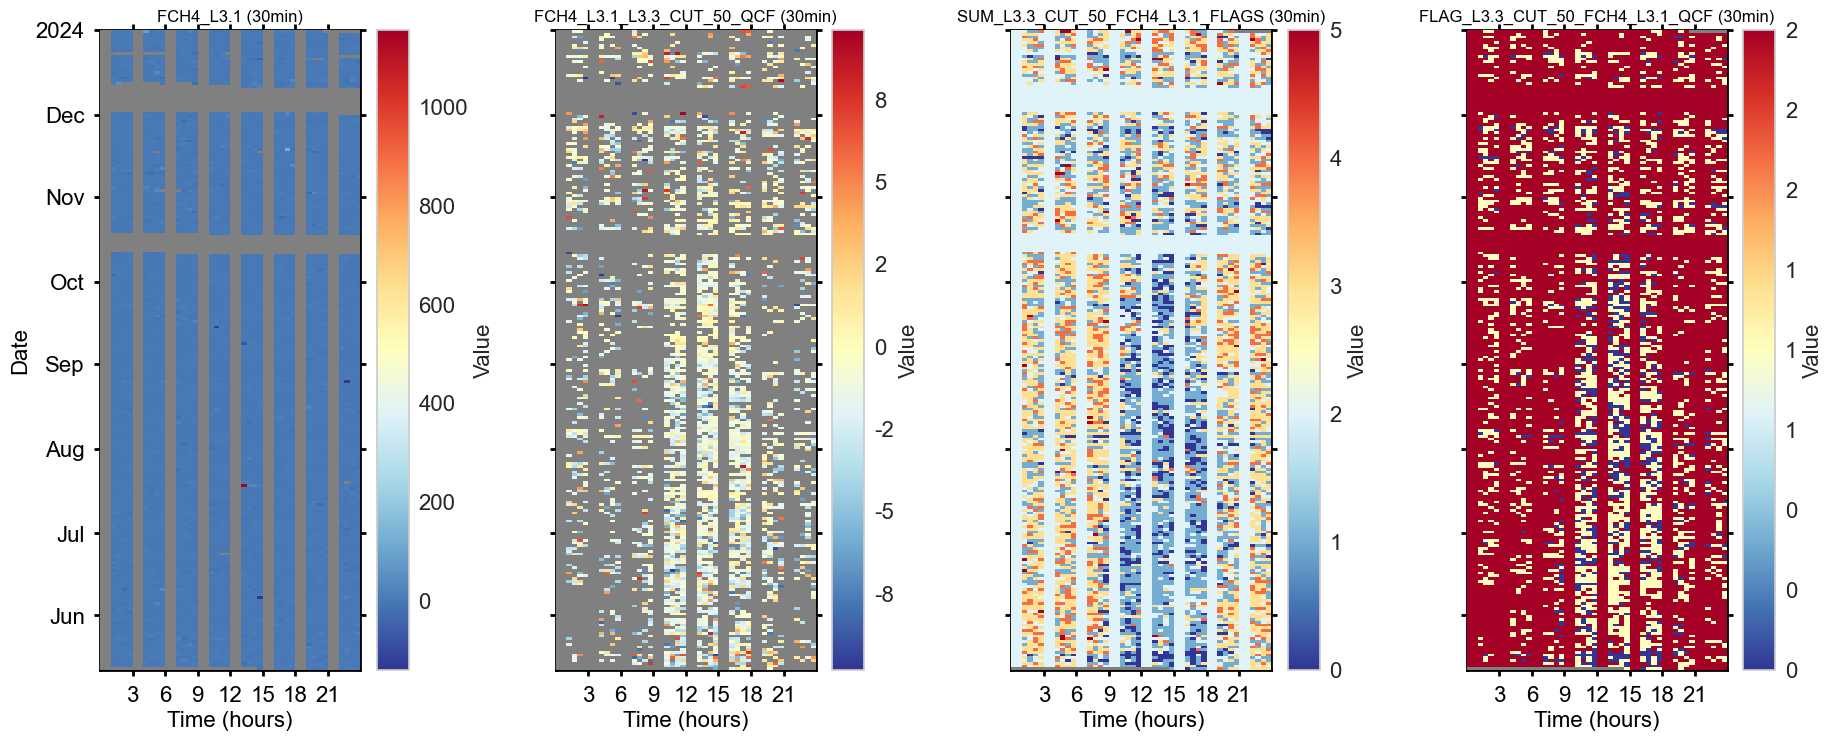

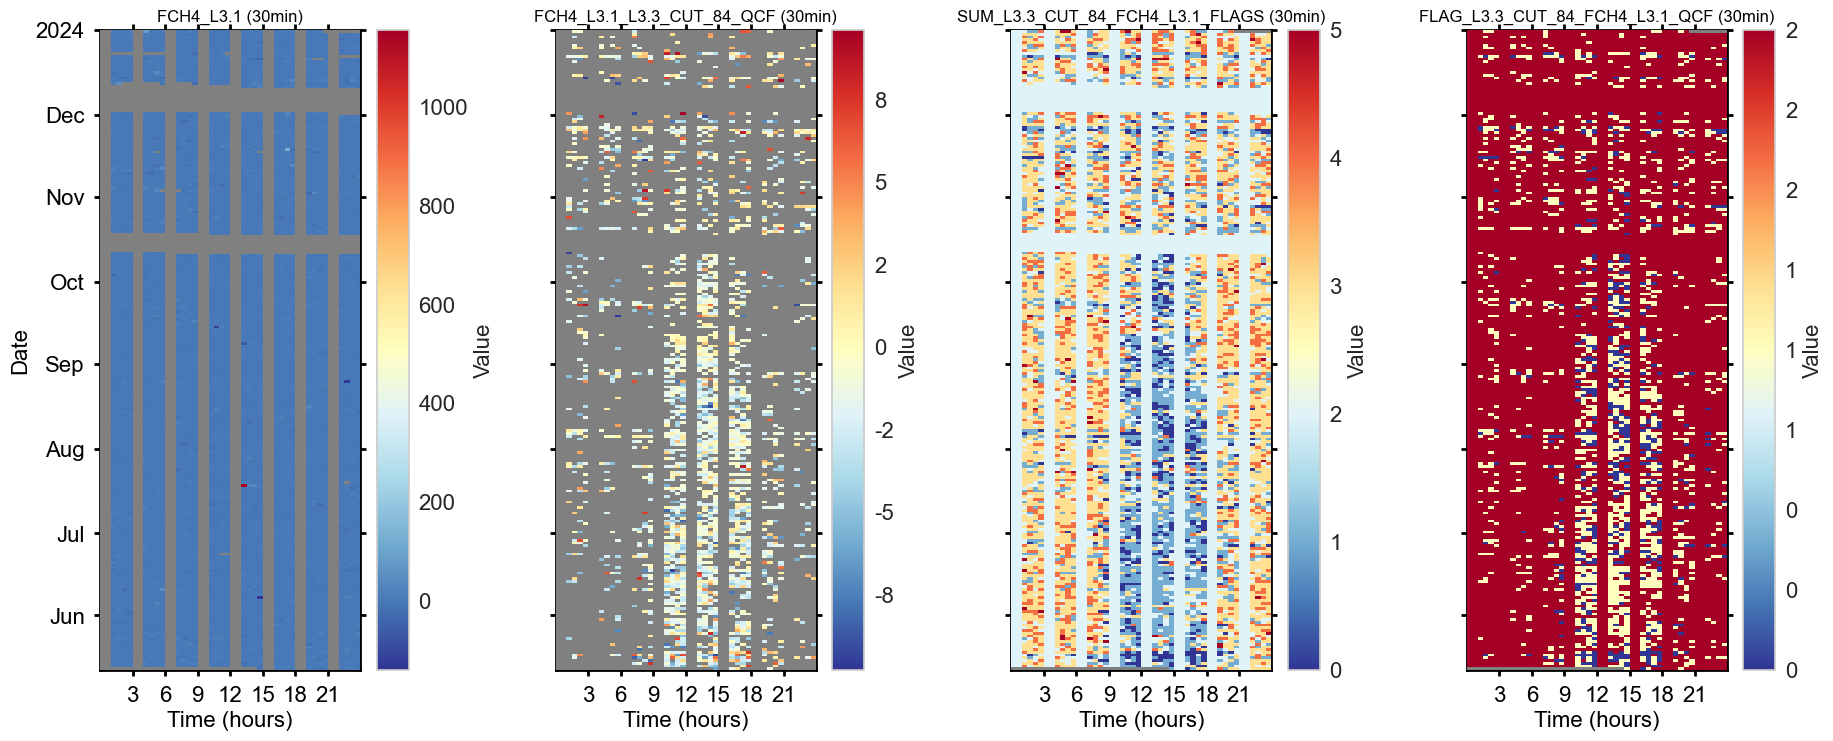

In [55]:
for key, value in fpc.level33_qcf.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    # TimeSeries(series=fpc.fpc_df[FLUXVAR33QCF[key].name]).plot()
    fpc.level33_qcf[key].showplot_qcf_heatmaps()

</br>

### Reports

In [56]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FCH4_L3.1.

Number of FCH4_L3.1 records before QC: 6898
+++ FLAG_L2_FCH4_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 6898 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FCH4_SSITC_TEST rejected 1516 values (+21.98%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 976 (14.15%) / flag 1: 4406 (63.87%) / flag 2: 1516 (21.98%)
+++ FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: f

In [57]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_series()



SUMMARY: FLAG_L3.3_CUT_16_FCH4_L3.1_QCF, QCF FLAG FOR FCH4_L3.1
Between 2023-05-12 14:45 and 2023-12-31 20:15 ...
    Total flux records BEFORE quality checks: 6898 (61.61% of potential)
    Available flux records AFTER quality checks: 3739 (54.20% of total)
    Rejected flux records: 3159 (45.80% of total)
    Potential flux records: 11196
    Potential flux records missed: 4298 (38.39% of potential)



SUMMARY: FLAG_L3.3_CUT_50_FCH4_L3.1_QCF, QCF FLAG FOR FCH4_L3.1
Between 2023-05-12 14:45 and 2023-12-31 20:15 ...
    Total flux records BEFORE quality checks: 6898 (61.61% of potential)
    Available flux records AFTER quality checks: 2789 (40.43% of total)
    Rejected flux records: 4109 (59.57% of total)
    Potential flux records: 11196
    Potential flux records missed: 4298 (38.39% of potential)



SUMMARY: FLAG_L3.3_CUT_84_FCH4_L3.1_QCF, QCF FLAG FOR FCH4_L3.1
Between 2023-05-12 14:45 and 2023-12-31 20:15 ...
    Total flux records BEFORE quality checks: 6898 (61.61% of potent

In [58]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FCH4_MISSING_TEST:
    OVERALL flag 0.0: 6898 values (61.61%)  
    OVERALL flag 2.0: 4298 values (38.39%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 3583 values (62.64%)  
    DAYTIME flag 2.0: 2137 values (37.36%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 3315 values (60.54%)  
    NIGHTTIME flag 2.0: 2161 values (39.46%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FCH4_SSITC_TEST:
    OVERALL flag 0.0: 976 values (8.72%)  
    OVERALL flag 1.0: 4406 values (39.35%)  
    OVERALL flag 2.0: 1516 values (13.54%)  
    OVERALL flag missing: 4298 values (38.39%)  

    DAYTIME flag 0.0: 653 values (11.42%)  
    DAYTIME flag 1.0: 2219 values (38.79%)  
    DAYTIME flag 2.0: 711 values (12.43%)  
    DAYTIME flag missing: 2137 values (37.36%)  

    NIGHTTIME flag 0.0: 323 values (5.90%)  
    NIGHTTIME flag 1.0: 2187 values (39.94%)  

</br>

</br>

## Overview: data after `Level-3.3`

## Flux variable names

In [59]:
fluxes_qcf = [c for c in fpc.fpc_df.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.3" in c]
fluxes_qcf0 = [c for c in fpc.fpc_df.columns if
               str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.3" in c]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

Quality-controlled fluxes: ['FCH4_L3.1_L3.3_CUT_16_QCF', 'FCH4_L3.1_L3.3_CUT_50_QCF', 'FCH4_L3.1_L3.3_CUT_84_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['FCH4_L3.1_L3.3_CUT_16_QCF0', 'FCH4_L3.1_L3.3_CUT_50_QCF0', 'FCH4_L3.1_L3.3_CUT_84_QCF0']


</br>

In [60]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"
FLUXVAR33QCF = fpc.filteredseries_level33_qcf

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print(
    f""
    f"{FLUXVAR} ... original input flux\n"
    f"{FLUXVAR2QCF} ... flux quality-controlled with Level-2 flags\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR31QCF} ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction\n   -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF} ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF_HQ} ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
)
print("Variables for further steps:")
for key, value in FLUXVAR33QCF.items():
    print(
        f"{FLUXVAR33QCF[key].name} ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering ({key}), including Level-3.1 storage correction\n-->   to be used in gap-filling and all further steps")

if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------
FCH4 ... original input flux
FCH4_L2_QCF ... flux quality-controlled with Level-2 flags
    -->  not used in any further processing steps
FCH4_L3.1_QCF ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction
   -->  not used in any further processing steps
FCH4_L3.1_L3.2_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps
FCH4_L3.1_L3.2_QCF0 ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps

Variables for further steps:
FCH4_L3.1_L3.3_CUT_16_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering (CUT_16), including Level-3.1 storage correction
-->   to be used in gap-filling and all further steps
FCH4_L

</br>

</br>

## Plot quality-controlled flux after `Level-3.3`
- Plot flux after storage-correction, flux quality control, outlier removal and USTAR filtering

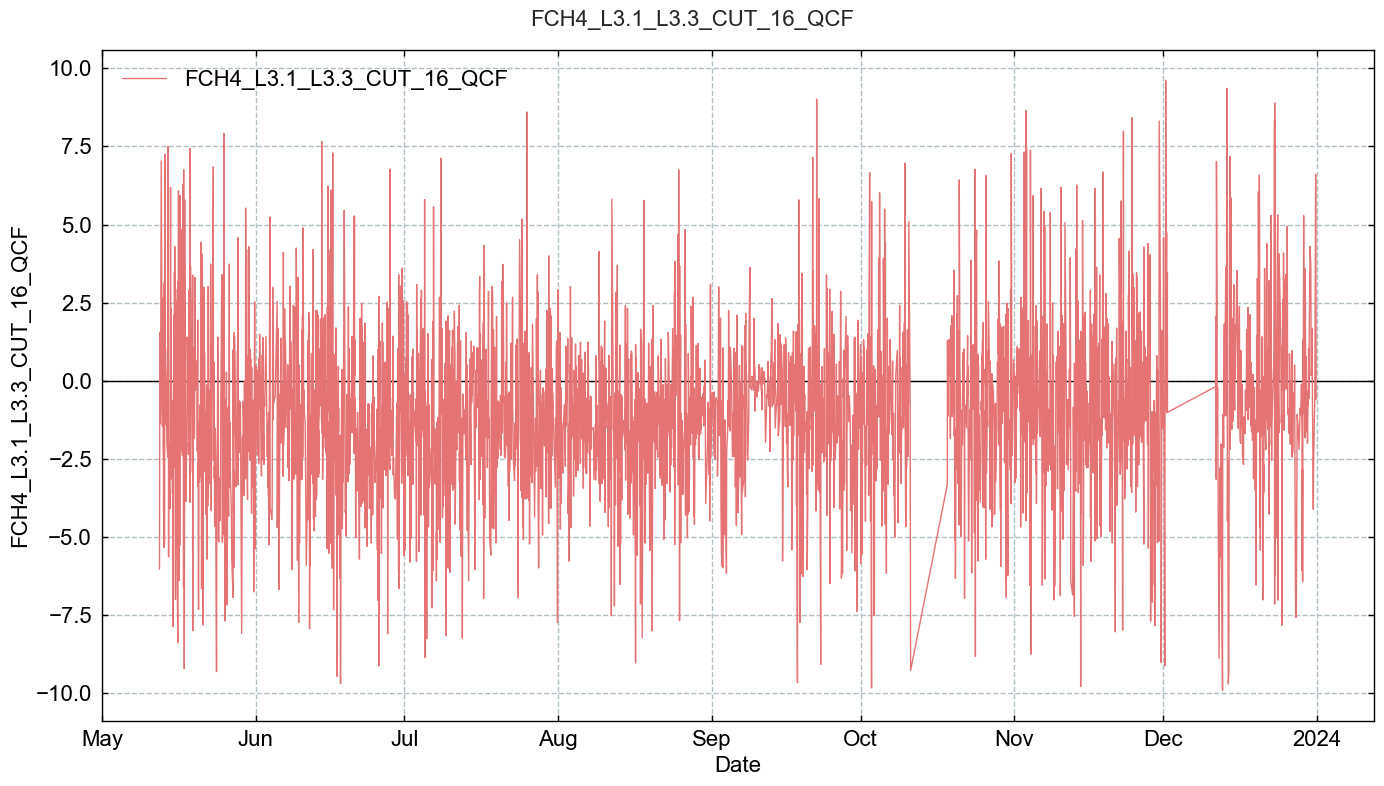

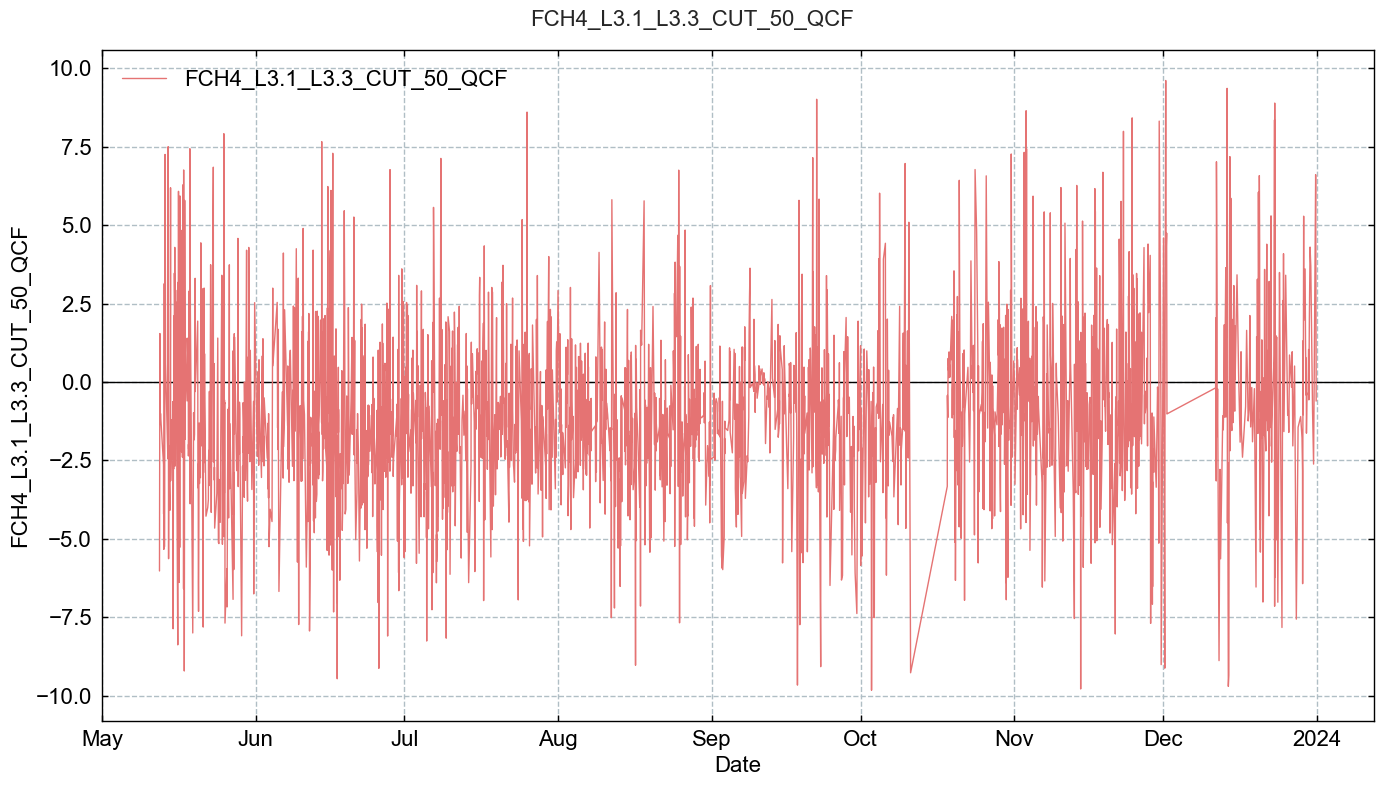

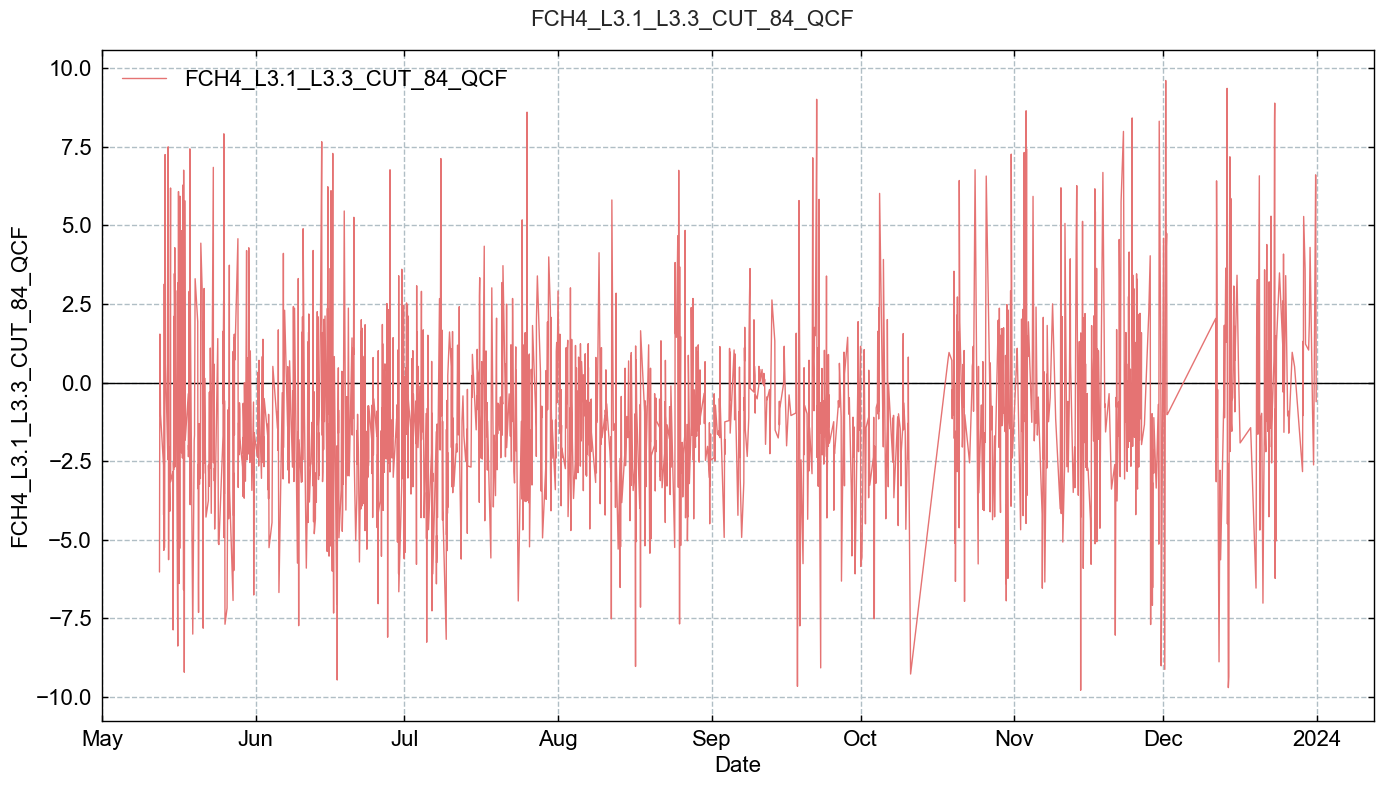

In [61]:
for key, value in FLUXVAR33QCF.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    TimeSeries(series=fpc.fpc_df[FLUXVAR33QCF[key].name]).plot()

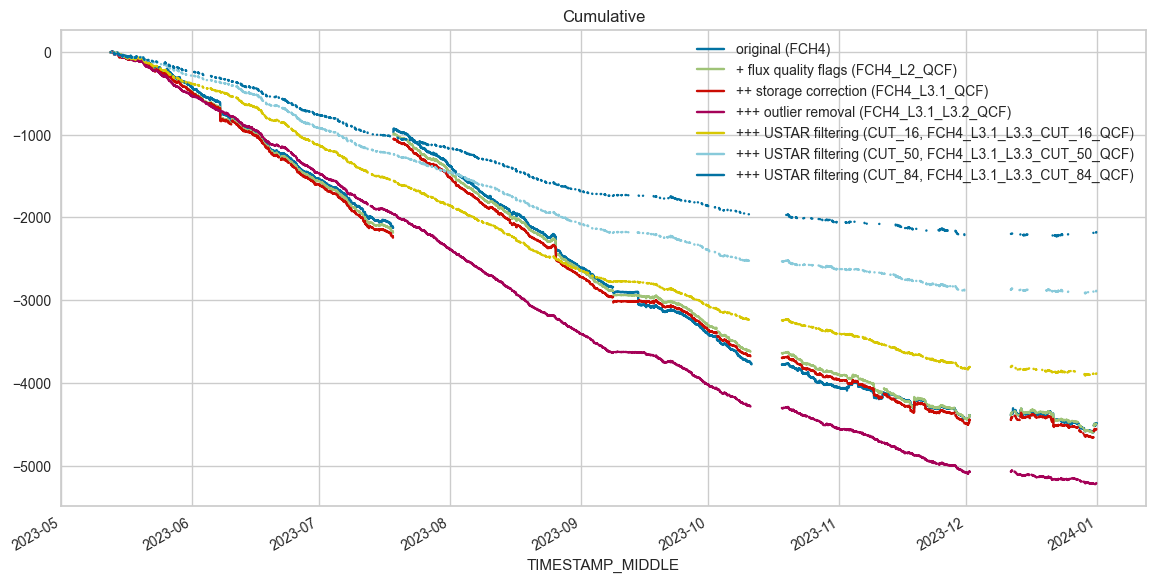

In [62]:
# Creating a dictionary by passing Series objects as values

frame = {
    f'original ({FLUXVAR})': fpc.fpc_df[FLUXVAR],
    f'+ flux quality flags ({FLUXVAR2QCF})': fpc.fpc_df[FLUXVAR2QCF],
    f'++ storage correction ({FLUXVAR31QCF})': fpc.fpc_df[FLUXVAR31QCF],
    f'+++ outlier removal ({FLUXVAR32QCF})': fpc.fpc_df[FLUXVAR32QCF]
}
for key, value in FLUXVAR33QCF.items():
    frame[f'+++ USTAR filtering ({key}, {FLUXVAR33QCF[key].name})'] = FLUXVAR33QCF[key]

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(14, 7), x_compat=True, alpha=1);

</br>

</br>

## Available `Level-3.3` fluxes

In [63]:
_fluxcols = [x for x in fpc.fpc_df.columns if
             'L3.1' and 'L3.3' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
_fluxcols

['FCH4_L3.1_L3.3_CUT_16_QCF',
 'FCH4_L3.1_L3.3_CUT_50_QCF',
 'FCH4_L3.1_L3.3_CUT_84_QCF']

In [64]:
_subset = fpc.fpc_df[_fluxcols].copy()
_subset.head()

FCH4_L3.1_L3.3_CUT_16_QCF  FCH4_L3.1_L3.3_CUT_50_QCF  FCH4_L3.1_L3.3_CUT_84_QCF
TIMESTAMP_MIDDLE                                                                                    
2023-05-12 14:45:00                  -6.021796                  -6.021796                  -6.021796
2023-05-12 15:15:00                        NaN                        NaN                        NaN
2023-05-12 15:45:00                        NaN                        NaN                        NaN
2023-05-12 16:15:00                  -1.511906                  -1.511906                  -1.511906
2023-05-12 16:45:00                   1.544808                   1.544808                   1.544808

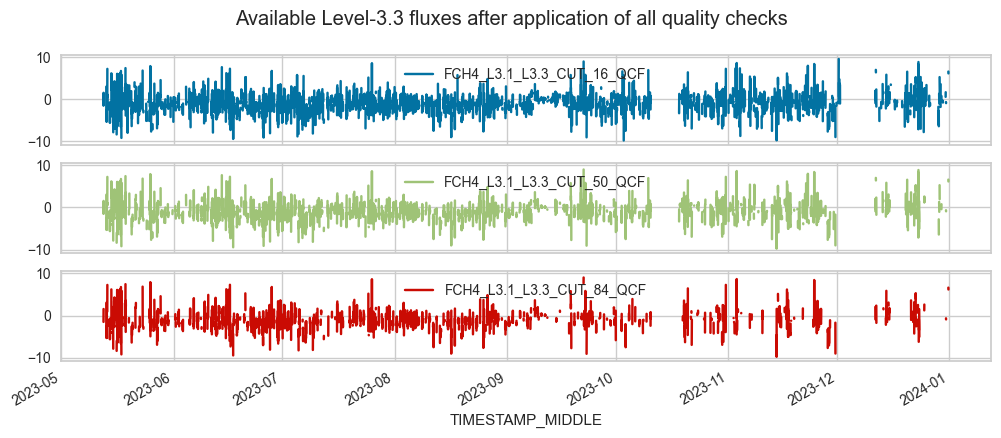

In [65]:
_subset.plot(subplots=True, x_compat=True,
             title="Available Level-3.3 fluxes after application of all quality checks", figsize=(12, 4.5));

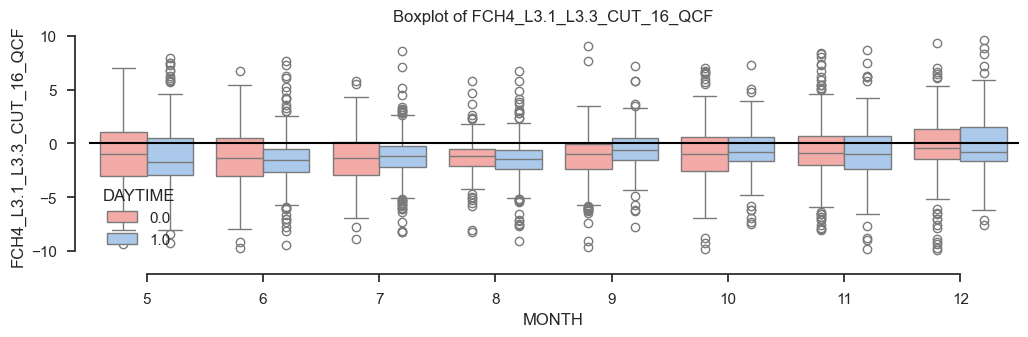

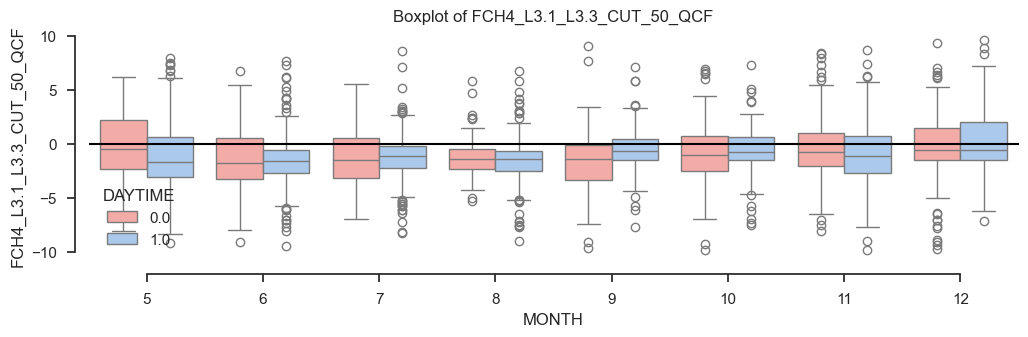

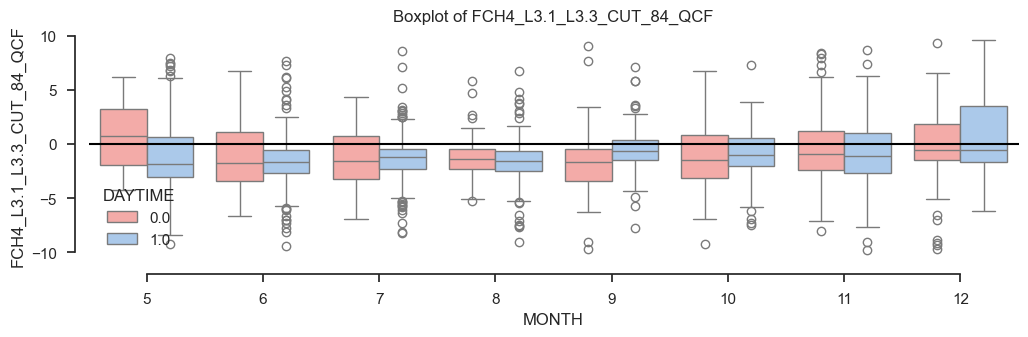

In [66]:
# Draw boxplots
for _f in _fluxcols:
    boxplots_df = fpc.fpc_df[[_f, "DAYTIME"]].copy()
    boxplots_df["MONTH"] = boxplots_df.index.month
    sns.set_theme(style="ticks", palette="pastel")
    plt.figure(figsize=(12, 3))
    sns.boxplot(x="MONTH", y=_f, palette=["r", "b"], hue="DAYTIME", data=boxplots_df).set_title(f"Boxplot of {_f}")
    sns.despine(offset=10, trim=True)
    plt.axhline(0, color="black");

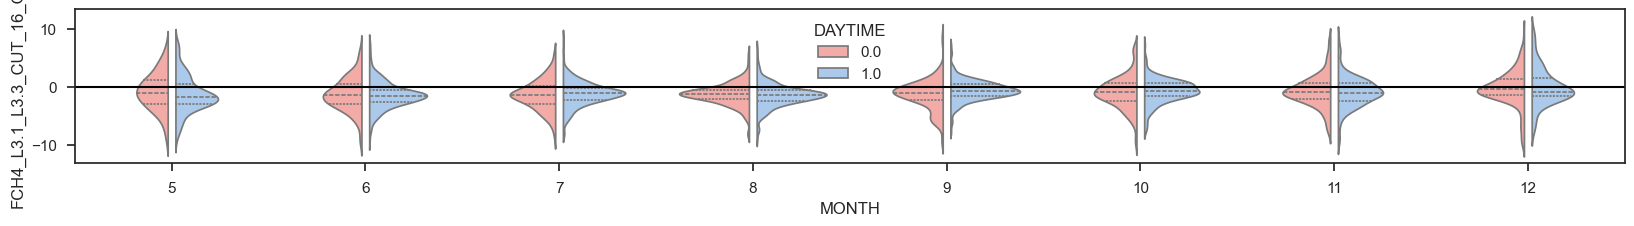

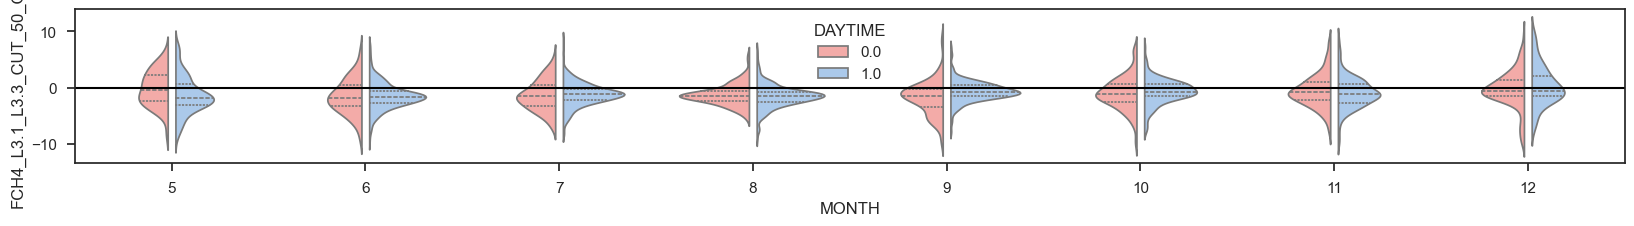

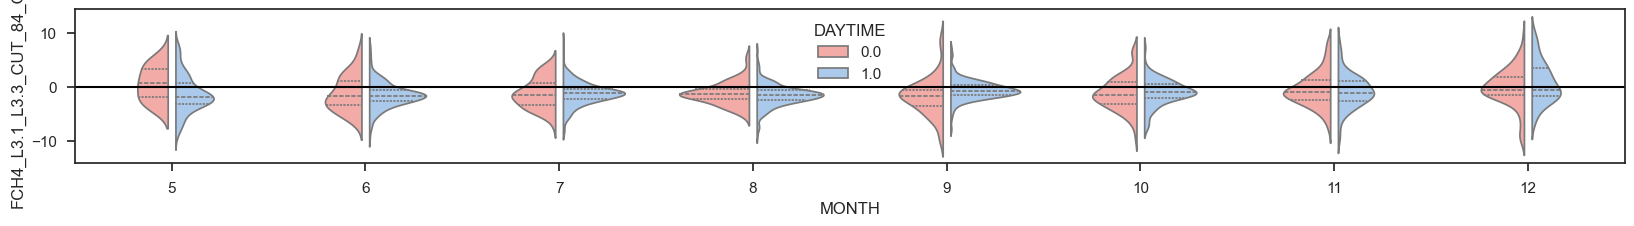

In [67]:
# Draw a nested violinplot and split the violins for easier comparison
for _f in _fluxcols:
    plt.figure(figsize=(20, 2))
    sns.violinplot(data=boxplots_df, x="MONTH", y=fpc.fpc_df[_f], hue="DAYTIME", split=True, palette=["r", "b"], gap=.1,
                   inner="quart")
    plt.axhline(0, color="black")

</br>

## Save Level-3.3 results to file
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. gap-filling should be done elsewhere (ReddyProc...)

In [ ]:
# results_df = fpc.get_data()
# filename = "51.1_FluxProcessingChain_after-L3.3_NEE"
# results_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=results_df, filename=filename)

</br>

# Level-4.1: **GAP-FILLING**

In [68]:
fpc.level41_gapfilling_longterm(
    run_random_forest=True,
    features=[],
    # features=["TA_T1_2_1", "SW_IN_T1_2_1", "VPD_T1_2_1"],
    features_lag=[-1, -1],
    # reduce_features=False,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    verbose=True,
    perm_n_repeats=3,
    rf_kwargs={
        'n_estimators': 200,
        'random_state': 42,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'n_jobs': -1
    }
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 11196.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2023-05-12 14:45:00 and 2023-12-31 20:15:00 ...
[neighboring_years] Assigned [2023] to data pool for 2023.
Initializing model for 2023 ...
Training model for 2023 ...

Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> based 

## Get results
- Results from the flux processing chain can be accessed using `.get_data()`
- This returns a dataframe containing all input data and all newly generated variables, such as quality flags, quality-filtered fluxes and gap-filled fluxes

In [69]:
results = fpc.get_data(verbose=1)
results

NEW VARIABLES FROM FLUX PROCESSING CHAIN:
++ DAYTIME
++ NIGHTTIME
++ FLAG_L2_FCH4_MISSING_TEST
++ FLAG_L2_FCH4_SSITC_TEST
++ FLAG_L2_FCH4_SCF_TEST
++ FLAG_L2_FCH4_CH4_VM97_SPIKE_HF_TEST
++ FLAG_L2_FCH4_CH4_VM97_AMPLITUDE_RESOLUTION_HF_TEST
++ FLAG_L2_FCH4_CH4_VM97_DROPOUT_TEST
++ SUM_L2_FCH4_HARDFLAGS
++ SUM_L2_FCH4_SOFTFLAGS
++ SUM_L2_FCH4_FLAGS
++ FLAG_L2_FCH4_QCF
++ FCH4_L2_QCF
++ FCH4_L2_QCF0
++ SCH4_SINGLE_gfRMED_L3.1
++ FLAG_SCH4_SINGLE_gfRMED_L3.1_ISFILLED
++ FCH4_L3.1
++ FCH4_L3.1_QCF
++ FCH4_L3.1_QCF0
++ FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_ABSLIM_TEST
++ FLAG_L3.2_FCH4_L3.1_QCF_OUTLIER_HAMPEL_TEST
++ SUM_L3.2_FCH4_L3.1_HARDFLAGS
++ SUM_L3.2_FCH4_L3.1_SOFTFLAGS
++ SUM_L3.2_FCH4_L3.1_FLAGS
++ FLAG_L3.2_FCH4_L3.1_QCF
++ FCH4_L3.1_L3.2_QCF
++ FCH4_L3.1_L3.2_QCF0
++ FLAG_L3.3_CUT_16_FCH4_L3.1_USTAR_TEST
++ SUM_L3.3_CUT_16_FCH4_L3.1_HARDFLAGS
++ SUM_L3.3_CUT_16_FCH4_L3.1_SOFTFLAGS
++ SUM_L3.3_CUT_16_FCH4_L3.1_FLAGS
++ FLAG_L3.3_CUT_16_FCH4_L3.1_QCF
++ FCH4_L3.1_L3.3_CUT_16_QCF
++ FCH4_L

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD     BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  BADM_INST_SA_WIND_FORMAT  BADM_INST_SA_GILL_ALIGN  BADM_SA_OFFSET_NORTH  BADM_INST_MODEL_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INST_GA_CP_TUBE_LENGTH_GA_CO2  BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CO2  ...  SUM_L3.3_CUT_16_FCH4_L3.1_SOFTFLAGS  SUM_L3.3_CUT_16_FCH4_L3.1_FLAGS  FLAG_L3.3_CUT_16_FCH4_L3.1_QCF  FCH4_L3.1_L3.3_CUT_16_QCF  FCH4_L3.1_L3.3_CUT_16_QCF0  FLAG_L3.3_CUT_50_FCH4_L3.1_USTAR_TEST  SUM_L3.3_CUT_50_FCH4_L3.1_HARDFLAGS  SUM_L3.3_CUT_50_FCH4_L3.1_SOFTFLAGS  SUM_L3.3_CUT_50_FCH4_L3.1_FLAGS  FLAG_L3.3_CUT_50_FCH4_L3.1_QCF  FCH4_L3.1_L3.3_CUT_50_QCF  FCH4_L3.1_L3.3_CUT_50_QCF0  FLAG_L3.3_CUT_84_FCH4_L3.1_USTAR_TEST  \
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ...                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-05-12 14:45:00  0.028234      1.02218     1032.87  1010.46         0.0                   1.0  0.349150           0.0            46.8154             9.85549              1652.0           0.2                    20.0                     30.0                 NaN                  2.1                       NaN                      NaN                   8.0                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...                                  1.0                              1.0                             1.0                  -6.021796                         NaN                                    0.0                                  0.0                                  1.0                              1.0                             1.0                  -6.021796                         NaN                                    0.0   
2023-05-12 15:15:00       NaN          NaN         NaN      NaN         NaN                   NaN       NaN           NaN                NaN                 NaN                 NaN           NaN                     NaN                      NaN                 NaN                  NaN                       NaN                      NaN                   NaN                     NaN                                 NaN                                NaN                              NaN                                 NaN                                  NaN  ...                                  0.0                              2.0                             2.0                        NaN                         NaN                                    0.0                                  2.0                                  0.0                              2.0                             2.0                        NaN                         NaN                                    0.0   
2023-05-12 15:45:00       NaN          

## Model scores

In [70]:
fpc.report_gapfilling_model_scores()


MODEL SCORES (random_forest): CUT_16
            2023
mae     1.033232
medae   0.641885
mse     2.591851
rmse    1.609923
mape    0.999912
maxe   14.106476
r2      0.577371

MODEL SCORES (random_forest): CUT_50
            2023
mae     1.079609
medae   0.665434
mse     2.855087
rmse    1.689700
mape    0.934915
maxe   11.594297
r2      0.565604

MODEL SCORES (random_forest): CUT_84
            2023
mae     1.131513
medae   0.714134
mse     3.100723
rmse    1.760887
mape    0.894466
maxe   12.131153
r2      0.562575


During long-term gap-filling, different years are pooled together to predict one central year, i.e., multiple models are used.  
The used data pools can be display with:

In [71]:
fpc.report_gapfilling_poolyears()

DATA POOLS USED FOR GAP_FILLING:
2023: random_forest used data from [2023] for gap-filling FCH4_L3.1_L3.3_CUT_16_QCF and producing --> FCH4_L3.1_L3.3_CUT_16_QCF_gfRF


2023: random_forest used data from [2023] for gap-filling FCH4_L3.1_L3.3_CUT_50_QCF and producing --> FCH4_L3.1_L3.3_CUT_50_QCF_gfRF


2023: random_forest used data from [2023] for gap-filling FCH4_L3.1_L3.3_CUT_84_QCF and producing --> FCH4_L3.1_L3.3_CUT_84_QCF_gfRF




## Names of gap-filled variables


In [72]:
print("Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:")
fpc.report_gapfilling_variables()

Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:
random_forest (CUT_16): FCH4_L3.1_L3.3_CUT_16_QCF -> FCH4_L3.1_L3.3_CUT_16_QCF_gfRF
random_forest (CUT_50): FCH4_L3.1_L3.3_CUT_50_QCF -> FCH4_L3.1_L3.3_CUT_50_QCF_gfRF
random_forest (CUT_84): FCH4_L3.1_L3.3_CUT_84_QCF -> FCH4_L3.1_L3.3_CUT_84_QCF_gfRF


In [73]:
gapfilled_names = fpc.get_gapfilled_names()
gapfilled_names

['FCH4_L3.1_L3.3_CUT_16_QCF_gfRF',
 'FCH4_L3.1_L3.3_CUT_50_QCF_gfRF',
 'FCH4_L3.1_L3.3_CUT_84_QCF_gfRF']

Gap-filled data can also be accessed directly. To get all gap-filled variables and also the same variables before gap-filling in a dataframe, use `.get_gapfilled_variables()`: 

In [74]:
gapfilled_vars = fpc.get_gapfilled_variables()
gapfilled_vars.head(3)

FCH4_L3.1_L3.3_CUT_16_QCF_gfRF  FCH4_L3.1_L3.3_CUT_50_QCF_gfRF  FCH4_L3.1_L3.3_CUT_84_QCF_gfRF  FCH4_L3.1_L3.3_CUT_16_QCF  FCH4_L3.1_L3.3_CUT_50_QCF  FCH4_L3.1_L3.3_CUT_84_QCF
TIMESTAMP_MIDDLE                                                                                                                                                                                    
2023-05-12 14:45:00                       -6.021796                       -6.021796                       -6.021796                  -6.021796                  -6.021796                  -6.021796
2023-05-12 15:15:00                       -1.197109                       -4.566023                       -4.659083                        NaN                        NaN                        NaN
2023-05-12 15:45:00                       -1.197109                       -4.004029                       -3.939057                        NaN                        NaN                        NaN

The names of the flux that was gap-filled can be accessed like this:

In [75]:
nongapfilled_names = fpc.get_nongapfilled_names()
nongapfilled_names

['FCH4_L3.1_L3.3_CUT_16_QCF',
 'FCH4_L3.1_L3.3_CUT_50_QCF',
 'FCH4_L3.1_L3.3_CUT_84_QCF']

## Plot: gap-filled heatmaps

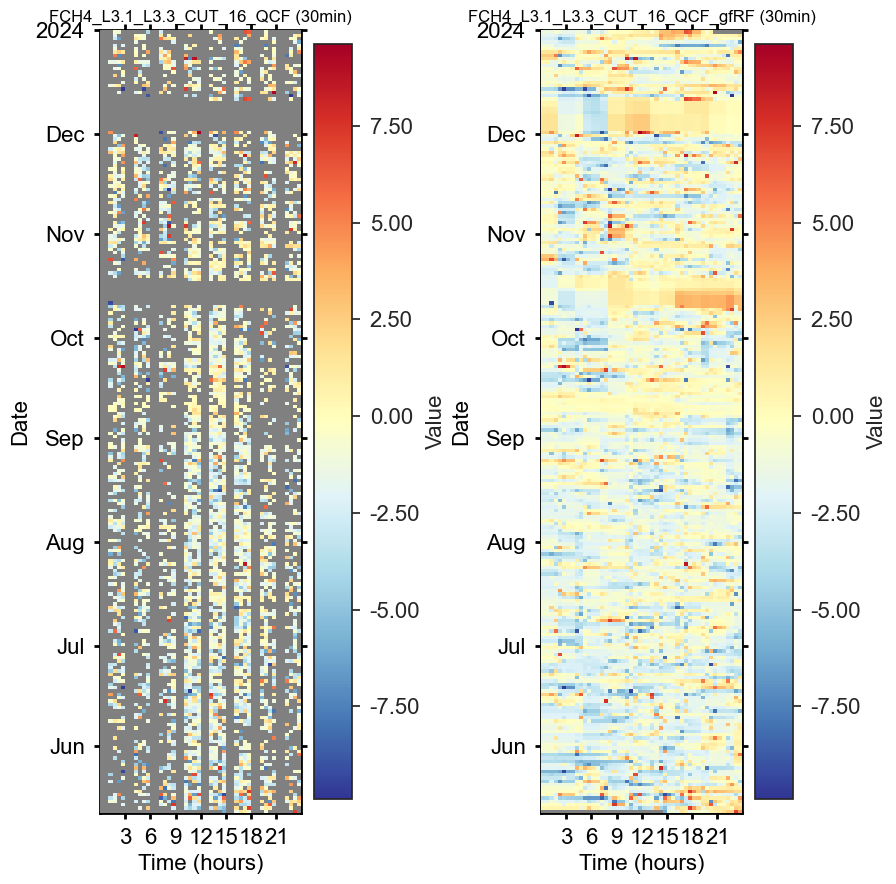

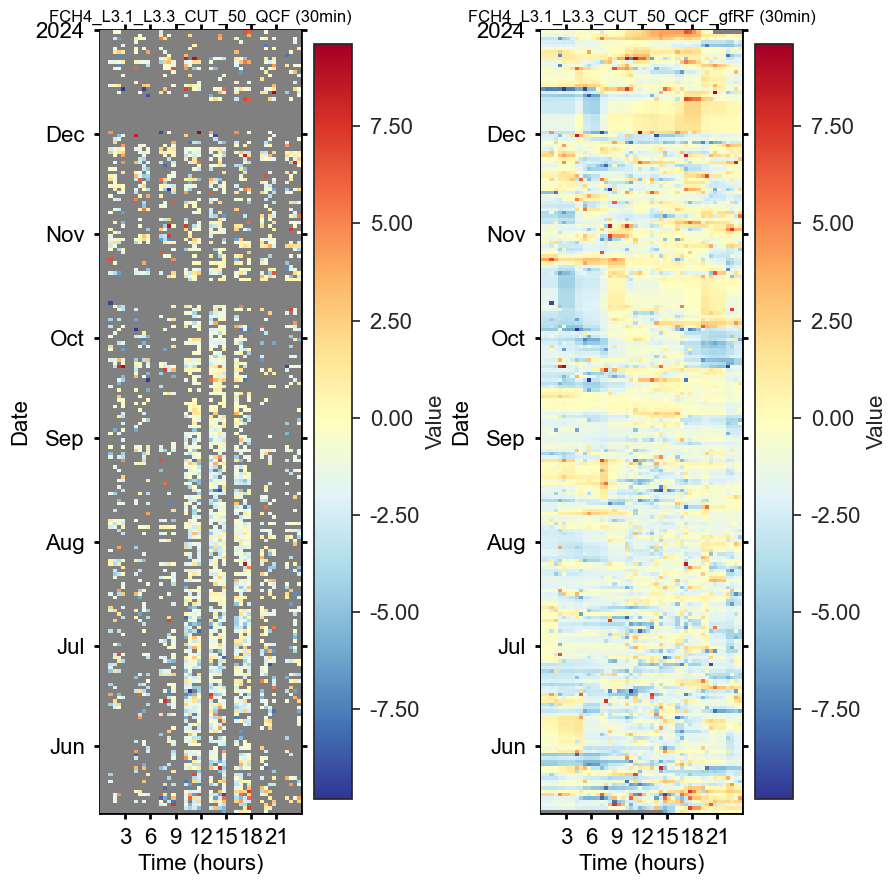

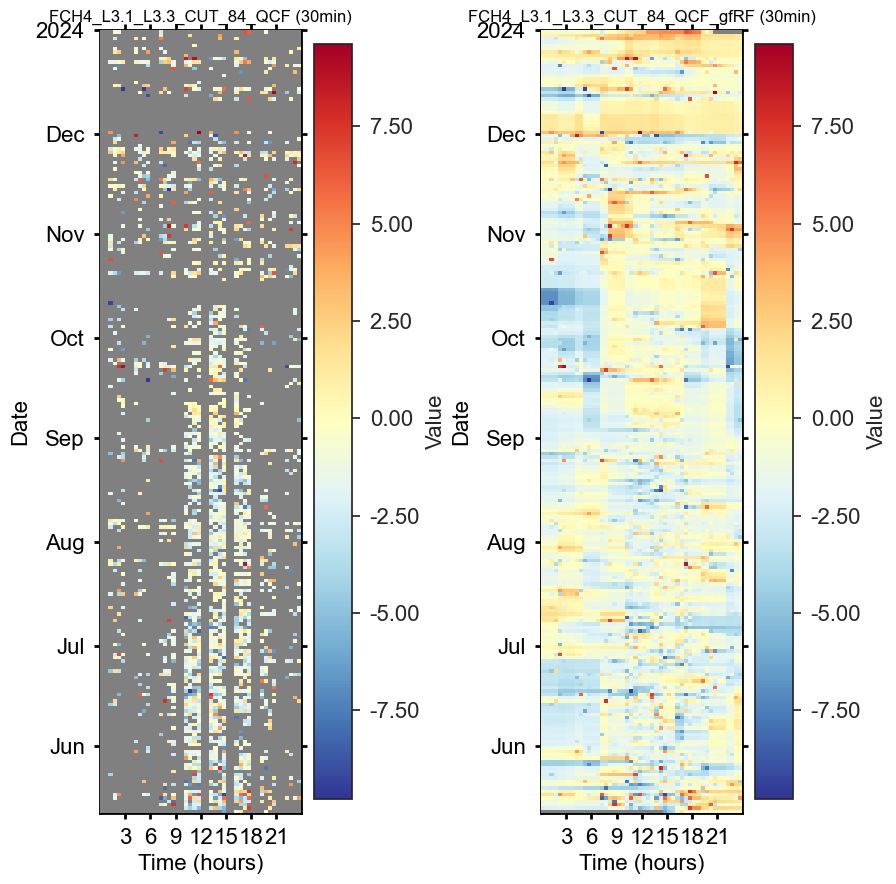

In [76]:
fpc.showplot_gapfilled_heatmap()

## Plot: Gap-filled cumulatives per year

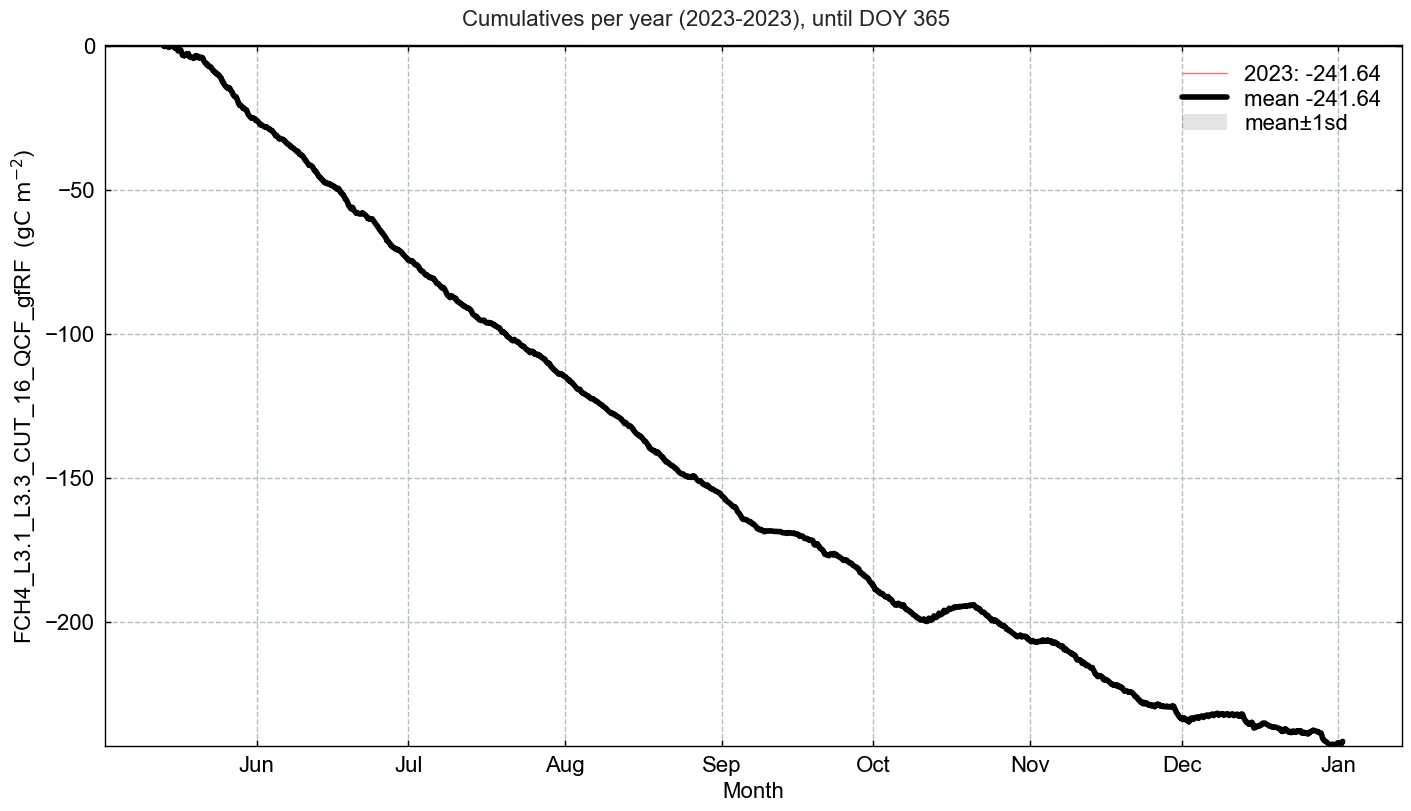

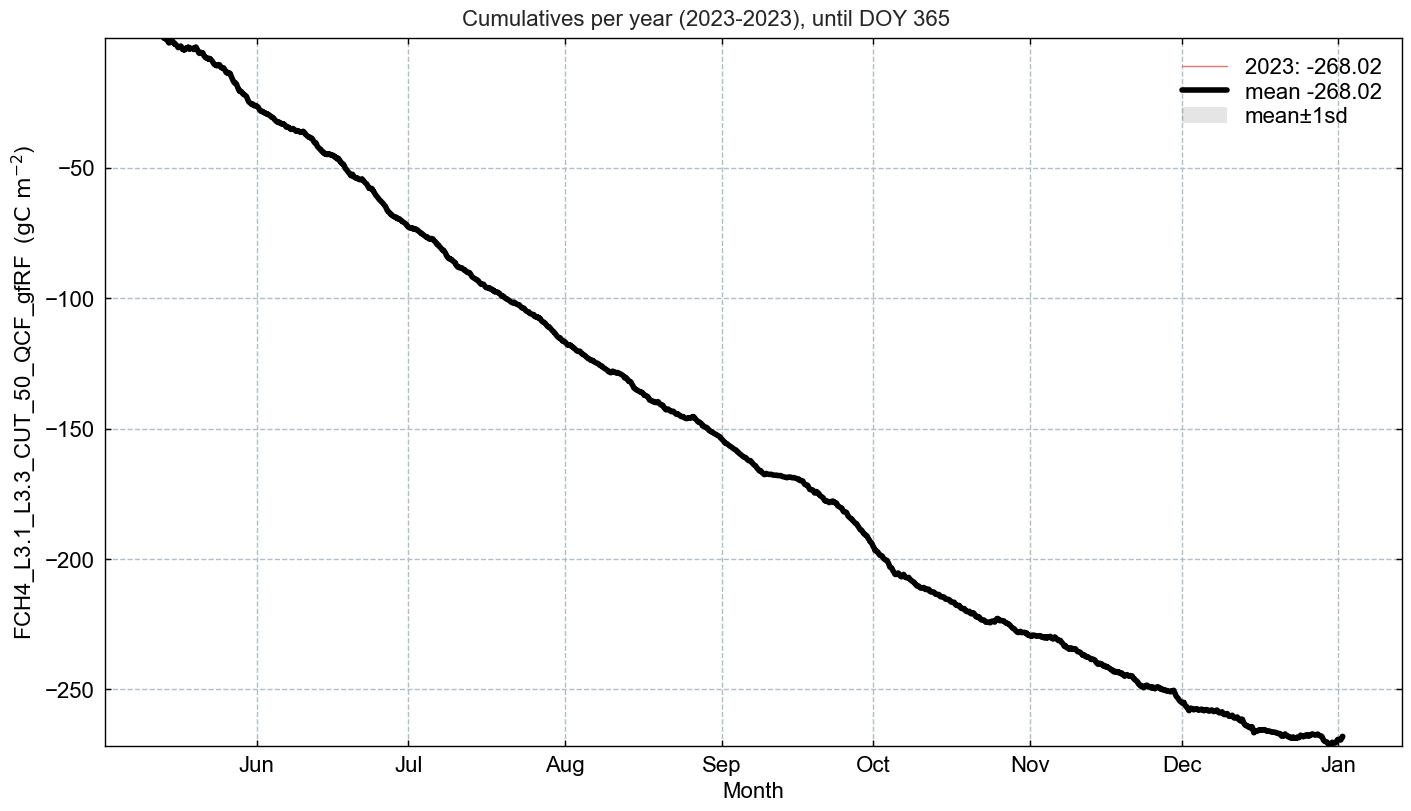

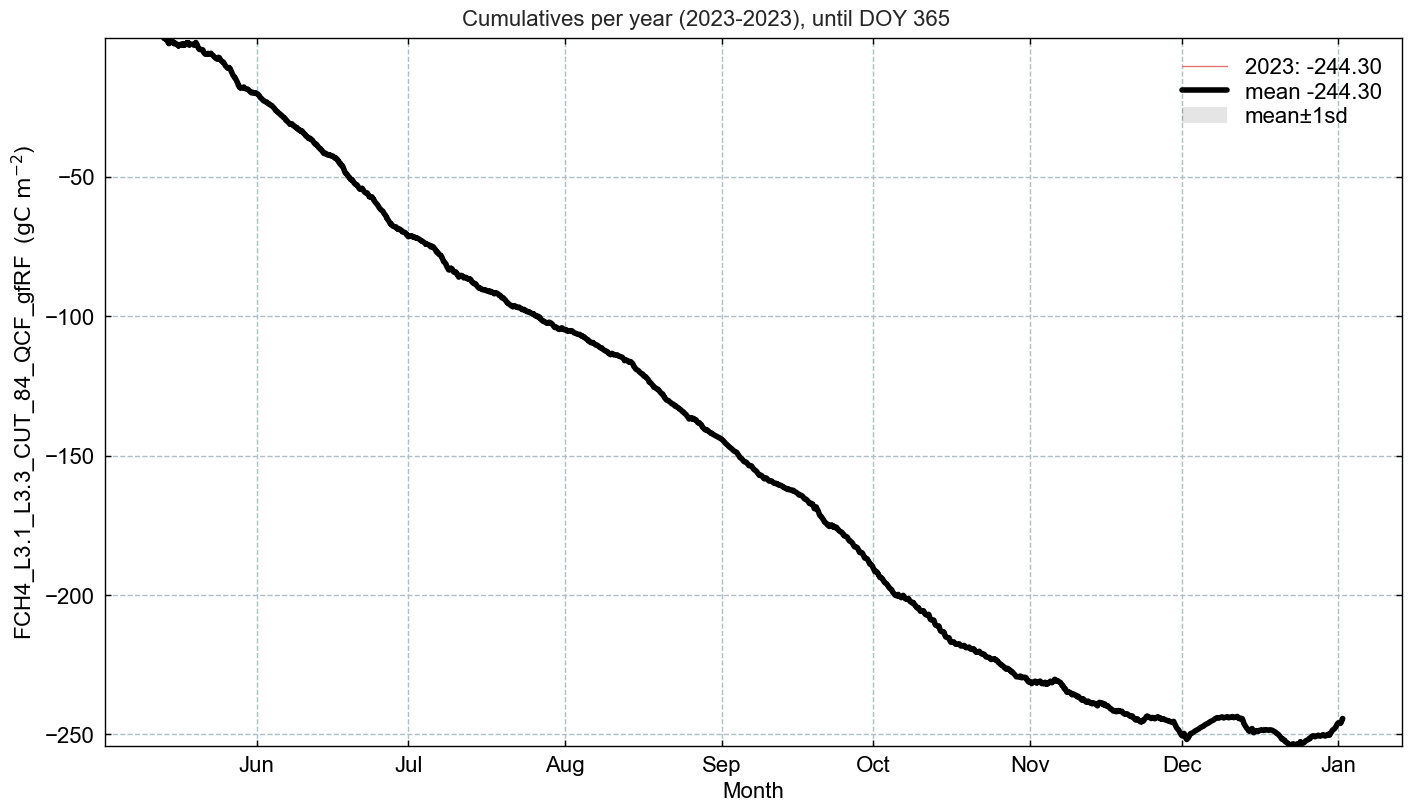

In [77]:
fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=True)

## Plot: gap-filled cumulative across all data 

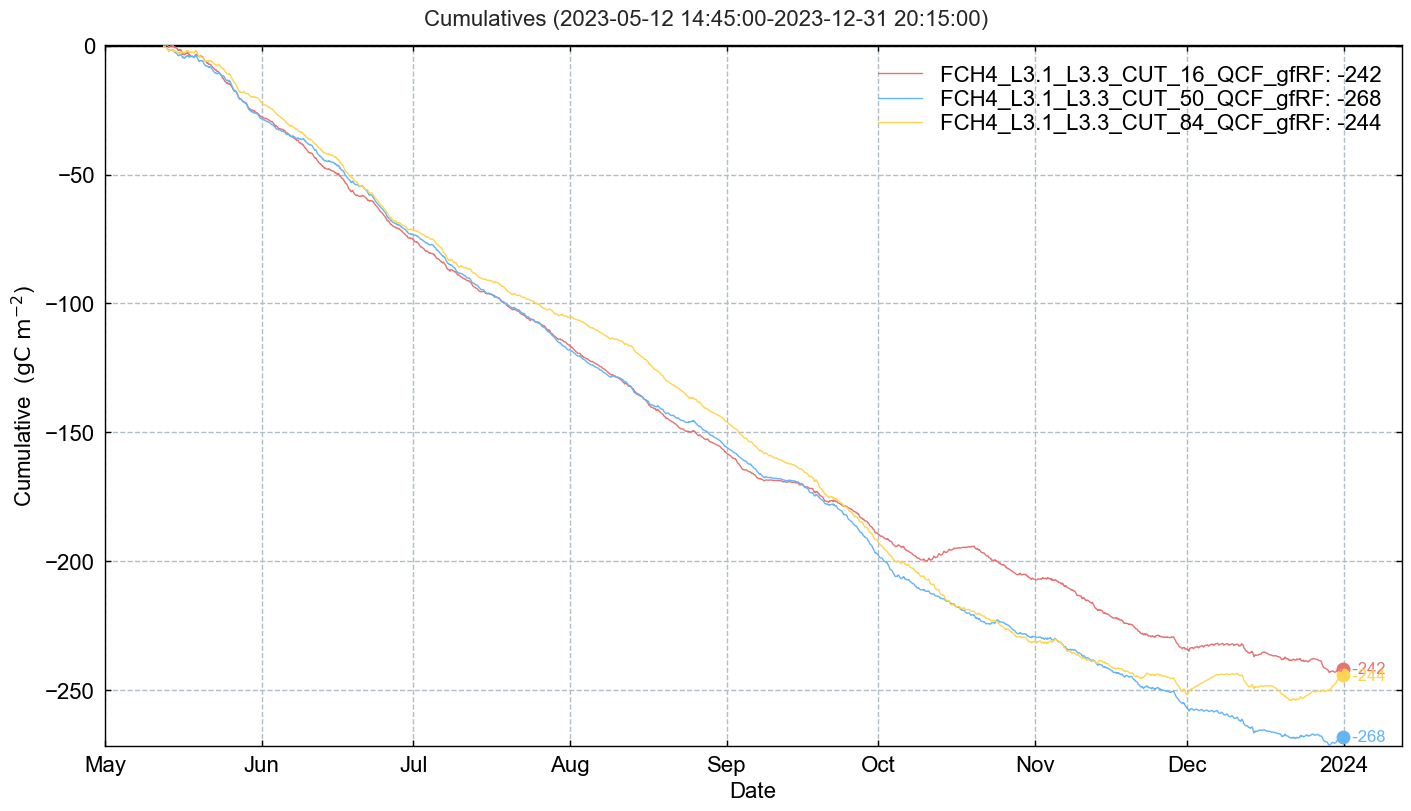

In [78]:
fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=False)

## Plot: model feature ranks per year

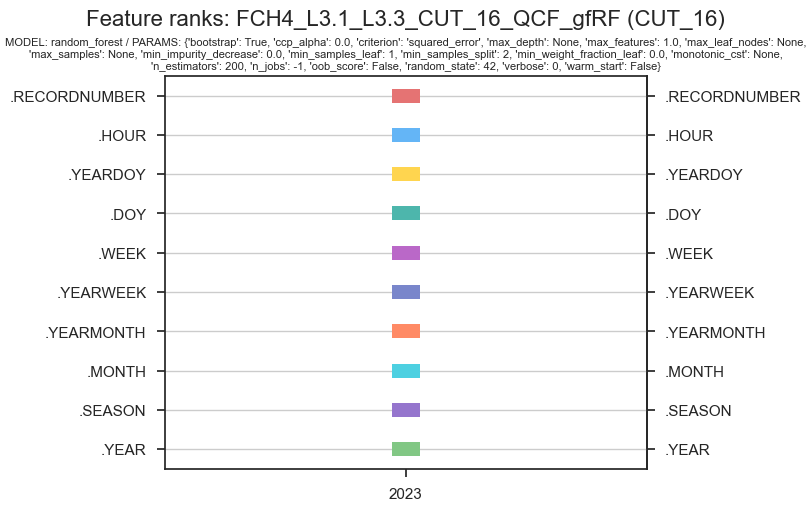

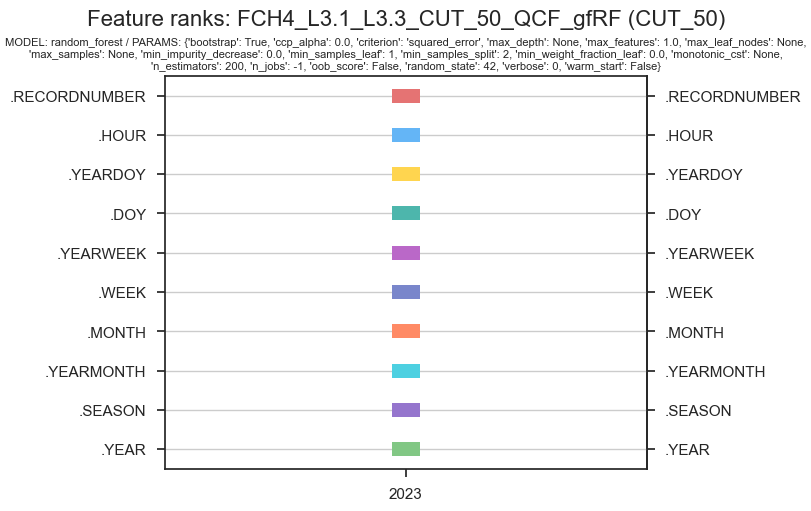

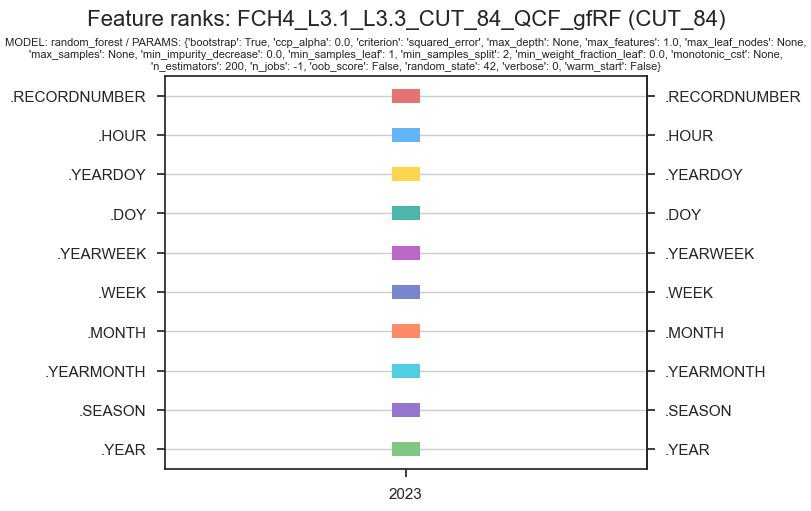

In [79]:
fpc.showplot_feature_ranks_per_year()

</br>

</br>

# Save results to file
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

## Option 1: Save to CSV (large and slow)

In [ ]:
# maindf2.to_csv("FluxProcessingChain_L3.2.csv")

</br>

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [ ]:
# save_parquet(data=results, filename="FluxProcessingChain_L4.1")

</br>

## Optional: *Impact of different USTAR thresholds on data availability*

In [ ]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios
ust = UstarThresholdConstantScenarios(series=results[FLUXVAR],
                                      swinpot=results['SW_IN_POT'],
                                      ustar=maindf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")